# Autoencoder for MNIST in Pytorch Lightning

In this notebook you will train an autoencoder for the MNIST dataset which is a dataset of handwritten digits. This is the last exercise where we will provide a structured skeleton. For future exercises, we will only provide the dataset, task as well as a test scenario for you to challenge yourself against your peers on our leaderboards.

You will use the PyTorch Lightning framework which makes everything much more convenient! In case you haven't done yet, you should definitely check out the **PyTorch Lightning Introduction** in **Exercise 7**! However, you will mostly design the network architectures as well as be left of to choose suitable hyperparameters for the task at handy, so superficial knowledge of pytorch lightning will suffice.

## What we will do:

One application of autoencoders is unsupervised pretraining with unlabeled data and then finetuning the encoder with labeled data. This can increase our performance if there is only little labeled data but a lot of unlabeled data available.

In this exercise you use the MNIST dataset with 60,000 images of handwritten digits, but you do not have all the labels available.

You will then train our autoencoder to reproduce the unlabeled images. 

Then you will transfer the pretrained encoder weights and finetune a classifier on the labeled data for classifying the handwritten digits. This is called **transfer learning**.

In [1]:
# For automatic file reloading as usual
%load_ext autoreload
%autoreload 2
%matplotlib inline

## (Optional) Mount folder in Colab

Uncomment the following cell to mount your gdrive if you are using the notebook in google colab:

In [2]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_08) is given.

"""
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_08'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present

SyntaxError: EOF while scanning triple-quoted string literal (2599786066.py, line 16)

### Set up PyTorch environment in colab
- (OPTIONAL) Enable GPU via Runtime --> Change runtime type --> GPU
- Uncomment the following cell if you are using the notebook in google colab:

In [3]:
# Optional: install correct libraries in google colab
# !python -m pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchtext==0.12.0+cu113 torchaudio==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html
# !python -m pip install tensorboard==2.8.0 > /dev/null
# !python -m pip install pytorch-lightning==1.6.0

# Imports

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt

import torch

from torchvision import transforms
import pytorch_lightning as pl
from exercise_code.image_folder_dataset import ImageFolderDataset
from pytorch_lightning.loggers import TensorBoardLogger
torch.manual_seed(42)

C:\Users\13021\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<div class="alert alert-warning">
    <h3>Note: Google Colab</h3>
    <p>
In case you don't have a GPU, you can run this notebook on Google Colab where you can access a GPU for free, but, of course, you can also run this notebook on your CPU.
         </p>
</div>

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Setup TensorBoard
In exercise 07 you've already learned how to use TensorBoard. Let's use it again to make the debugging of our network and training process more convenient! Throughout this notebook, feel free to add further logs or visualizations to your TensorBoard!

In [6]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6006

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

# 1. The MNIST Dataset

First, you download the dataset. MNIST is a dataset of 60,000 images depicting handwritten digits. However, as with most datasets, labeling is a costly process and therefore we are left in a pickle.

A good starting point is to label a small subset of your images. You either do this yourself but in this instance we consider the case where you hired another student to do it for you. After writing a labeling tool and some time, you are provided with 300 labeled images of which 100 will be used for training, 100 for validation, and 100 for testing. A problematic small number...

Feel free to define some transforms now or later (you can also pass without any transforms).

**Note**: We do **NOT** apply any transformations to test set at the time of final evaluation on the server.

In [7]:
########################################################################
# TODO: Feel free to define transforms                                 #
########################################################################

# transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5))])
transform=transforms.Normalize((0.5), (0.5))
########################################################################
#                           END OF YOUR CODE                           #
########################################################################

i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
mnist_root = os.path.join(i2dl_exercises_path, "datasets", "mnist")

train = ImageFolderDataset(root=mnist_root,images='train_images.pt',labels='train_labels.pt',force_download=False,verbose=True,transform=transform)
val = ImageFolderDataset(root=mnist_root,images='val_images.pt',labels='val_labels.pt',force_download=False,verbose=True,transform=transform)
test = ImageFolderDataset(root=mnist_root,images='test_images.pt',labels='test_labels.pt',force_download=False,verbose=True,transform=transform)

# We also set up the unlabeled images which we will use later
unlabeled_train = ImageFolderDataset(root=mnist_root,images='unlabeled_train_images.pt',force_download=False,verbose=True,transform=transform)
unlabeled_val = ImageFolderDataset(root=mnist_root,images='unlabeled_val_images.pt',force_download=False,verbose=True,transform=transform)

Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.dvl.in.tum.de/downloads/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.dvl.in.tum.de/downloads/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.dvl.in.tum.de/downloads/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.dvl.in.tum.de/downloads/mnist.zip
Found dataset folder. Skipped downloading. If you face issues, please re-download the dataset using
'--force_download=True'
https://i2dl.dvl.in.tum.de/downloads/mnist.zip


The dataset consists of tuples of 28x28 pixel PIL images and a label that is an integer from 0 to 9. 

Let's turn a few of the images into numpy arrays, to look at their shape and visualize them and see if the labels we paid for are correct.

The shape of our greyscale images:  (28, 28)


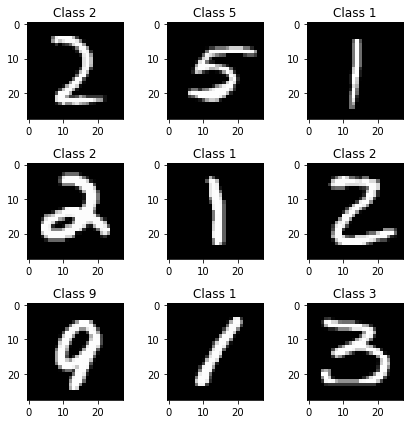

In [8]:
plt.rcParams['figure.figsize'] = (6,6) # Make the figures a bit bigger

for i in range(9):
    image = np.array(train[i][0].squeeze()) # get the image of the data sample
    label = train[i][1] # get the label of the data sample
    plt.subplot(3,3,i+1)
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.title("Class {}".format(label))
    
plt.tight_layout()
print('The shape of our greyscale images: ', image.shape)

<div class="alert alert-warning">
    <h3>Note: Starting Simple</h3>
    <p>
Regardless of the size of our dataset, the first step we have to take is to evaluate the performance of a simple classifier. Always approach a problem with a simple approach first and go from there to see which changes are helping you.
         </p>
</div>

# 2. A Simple Classifier

In `exercise_code/models.py` we prepared all classes for you which you will finalize throughout the notebook to build an Autoencoder and an image classifier with Pytorch Lightning. If you are unfamiliar with Pytorch Lightning, you can check out the notebook from the last exercise.

![network_split](img/network_split.png)

## 2.1 The Encoder

Different to previous models, we are going to split up our model into two parts: the so called `encoder` and the `classifier`. The `classifier` has a static task as it will output our predictions given a one-dimensional input. The `encoder`'s task is to extract meaningful information out of our input so that the classifier can make a proper decision. Right now however, both networks will be consisting of linear layers coupled with auxiliary ones and therefore won't be too different in their design. This split-up will be relevant later, e.g., by using convolutional layers which are introduced in the lecture. We are going to set up the `encoder` now. 

Think about a good network architecture. You're completely free here and can come up with any network you like! (\*)

Have a look at the documentation of `torch.nn` at https://pytorch.org/docs/stable/nn.html to learn how to use this module to build your network!

Then implement your architecture: initialize it in `__init__()` and assign it to `self.model`. This is particularly easy using `nn.Sequential()` which you only have to pass the list of your layers. 

To make your model customizable and support parameter search, don't use hardcoded hyperparameters - instead, pass them as dictionary `hparams` (here, `n_hidden` is the number of neurons in the hidden layer) when initializing `models`.

Here's an simple example:

```python
        self.model = nn.Sequential(
            nn.Linear(input_size, self.hparams["n_hidden"]),
            nn.ReLU(),            
            nn.Linear(self.hparams["n_hidden"], num_classes)
        )
```

Have a look at the forward path in `forward(self, x)`, which is so easy that you don't need to implement it yourself.

As PyTorch automatically computes the gradients, that's all we need to do! No need to manually calculate derivatives for the backward paths anymore! :)


____
\* *The size of your final model must be less than 20 MB, which is approximately equivalent to 5 Mio. params. Note that this limit is quite lenient, you will probably need much less parameters!*

*In order to keep things simple, you should only use fully connected layers for this task as we need to revert the encoder architecture  later on in the notebook.*

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>Encoder</code> class initialization in <code>exercise_code/models.py</code>.
    </p>
</div>

## 2.2 The Classifier

Now we are implementing our classifier. It will use the encoder network that you have defined in the above cell. By looking at `Classifier.forward`, you can see that we are simply chaining the `classifier` as well as the `encoder` together. Therefore, you have to match the input shape of the classifier to the output shape of your encoder implemented above. 

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>Classifier</code> class network initialization in <code>exercise_code/models.py</code>.
    </p>
</div>

## 2.3 Training & Validation Step

In pytorch lightning, you only have to provide a training step and a validation step. We implemented both for you, but please check the codes out to make sure that you understand them.


<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>Have a look at the functions <code>training_step</code> and <code>validation_step</code> of the <code>Classifier</code> class in <code>exercise_code/models.py</code>, that take a batch as input and calculate the loss. 
 </p>
</div>

## 2.4 Optimizer
Lastly, implement the function `configure_optimizers()` to define your optimizer. Here the documentation of `torch.optim`at https://pytorch.org/docs/stable/optim.html might be helpful.

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>configure_optimizers</code> method of the <code>Classifier</code> in <code>exercise_code/models.py</code>.
    </p>
</div>



In [10]:
from exercise_code.models import Encoder
from exercise_code.models import Classifier

########################################################################
# TODO: Define your hyper parameters here!                             #
########################################################################

hparams = {"batch_size":32,
           "lr":5e-4,
           "weight_decay":1e-3,
           "nn_hidden_layer1":1024,
           "nn_hidden_layer2":512,
#            "nn_hidden_layer3":128,
           "num_classes":10,
    
}

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

encoder = Encoder(hparams)
classifier = Classifier(hparams, encoder, train, val, test)

## 2.5 Fit Classification Model with Trainer
Now it's time to train your model.

Have a look of the documentation of `pl.Trainer` at https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html to find out which arguments you can pass to define your training process.

Then, you can start the training with `trainer.fit(classifier)` and have a look at the loss and the training accuracy in TensorBoard.

In [11]:
import copy
trainer = None
cls_logger = TensorBoardLogger(save_dir='lightning_logs', name="cĺs_logs")

trainer = pl.Trainer(
    max_epochs=500,
    logger=cls_logger,
    log_every_n_steps=100,
    gpus=1 if torch.cuda.is_available() else None
)

trainer.fit(classifier) # train the standard classifier
print("Validation accuracy when training from scratch: {}%".format(classifier.getAcc(classifier.val_dataloader())[1]*100))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Encoder    | 1.3 M 
1 | model   | Sequential | 5.1 K 
---------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.335     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|                                                              | 0/2 [00:01<?, ?it/s]

C:\Users\13021\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\13021\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\13021\AppData\Roaming\Python\Python38\site-packages\pytorch_lightning\trainer\trainer.py:1938: PossibleUserWarning: The number of training samples (4) is smaller than the logging interval Trainer(log_every_n_steps=100). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  50%|███████████████████████████                           | 4/8 [00:00<00:00, 95.22it/s, loss=2.28, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|███████████████████████████                           | 4/8 [00:00<00:00, 29.84it/s, loss=2.28, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|███████████████████████████                           | 4/8 [00:00<00:00, 17.16it/s, loss=2.27, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|███████████████████████████                           | 4/8 [00:00<00:00, 12.23it/s, loss=2.26, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|███████████████████████████                           | 4/8 [00:00<00:00,  9.32it/s, loss=2.26, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|███████████████████████████                           | 4/8 [00:00<00:00,  7.56it/s, loss=2.24, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|███████████████████████████                           | 4/8 [00:00<00:00,  6.41i

Epoch 11:  50%|██████████████████████████▌                          | 4/8 [00:01<00:01,  3.66it/s, loss=2.17, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 12:  50%|██████████████████████████▌                          | 4/8 [00:01<00:01,  3.38it/s, loss=2.17, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 13:  50%|██████████████████████████▌                          | 4/8 [00:01<00:01,  3.11it/s, loss=2.15, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 14:  50%|██████████████████████████▌                          | 4/8 [00:01<00:01,  2.90it/s, loss=2.14, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 15:  50%|██████████████████████████▌                          | 4/8 [00:01<00:01,  2.71it/s, loss=2.12, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 16:  50%|███████████████████████████                           | 4/8 [00:01<00:01,  2.56it/s, loss=2.1, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 17:  50%|██████████████████████████▌                          | 4/8 [00:01<00:01,  2.41i

Epoch 21:  50%|██████████████████████████▌                          | 4/8 [00:02<00:02,  1.97it/s, loss=2.05, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 22:  50%|██████████████████████████▌                          | 4/8 [00:02<00:02,  1.88it/s, loss=2.04, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 23:  50%|██████████████████████████▌                          | 4/8 [00:02<00:02,  1.80it/s, loss=2.03, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 24:  50%|██████████████████████████▌                          | 4/8 [00:02<00:02,  1.73it/s, loss=2.02, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 25:  50%|████████████████████████████                            | 4/8 [00:02<00:02,  1.65it/s, loss=2, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 26:  50%|██████████████████████████▌                          | 4/8 [00:02<00:02,  1.59it/s, loss=1.99, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 27:  50%|██████████████████████████▌                          | 4/8 [00:02<00:02,  1.54i

Epoch 32:  50%|██████████████████████████▌                          | 4/8 [00:03<00:03,  1.31it/s, loss=1.99, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|██████████████████████████▌                          | 4/8 [00:03<00:03,  1.28it/s, loss=1.97, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|██████████████████████████▌                          | 4/8 [00:03<00:03,  1.24it/s, loss=1.96, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|██████████████████████████▌                          | 4/8 [00:03<00:03,  1.21it/s, loss=1.94, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|██████████████████████████▌                          | 4/8 [00:03<00:03,  1.18it/s, loss=1.93, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|██████████████████████████▌                          | 4/8 [00:03<00:03,  1.15it/s, loss=1.94, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 38:  50%|██████████████████████████▌                          | 4/8 [00:03<00:03,  1.12i

Epoch 42:  50%|██████████████████████████▌                          | 4/8 [00:03<00:03,  1.02it/s, loss=1.92, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 43:  50%|███████████████████████████                           | 4/8 [00:04<00:04,  1.00s/it, loss=1.9, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 44:  50%|███████████████████████████                           | 4/8 [00:04<00:04,  1.02s/it, loss=1.9, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 45:  50%|██████████████████████████▌                          | 4/8 [00:04<00:04,  1.05s/it, loss=1.87, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 46:  50%|██████████████████████████▌                          | 4/8 [00:04<00:04,  1.07s/it, loss=1.84, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 47:  50%|██████████████████████████▌                          | 4/8 [00:04<00:04,  1.09s/it, loss=1.81, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 48:  50%|███████████████████████████                           | 4/8 [00:04<00:04,  1.12

Epoch 53:  50%|███████████████████████████                           | 4/8 [00:04<00:04,  1.23s/it, loss=1.8, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 54:  50%|███████████████████████████                           | 4/8 [00:05<00:05,  1.26s/it, loss=1.8, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 55:  50%|███████████████████████████                           | 4/8 [00:05<00:05,  1.28s/it, loss=1.8, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 56:  50%|███████████████████████████                           | 4/8 [00:05<00:05,  1.30s/it, loss=1.8, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 57:  50%|██████████████████████████▌                          | 4/8 [00:05<00:05,  1.33s/it, loss=1.82, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|██████████████████████████▌                          | 4/8 [00:05<00:05,  1.35s/it, loss=1.78, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|██████████████████████████▌                          | 4/8 [00:05<00:05,  1.37s

Epoch 63:  50%|██████████████████████████▌                          | 4/8 [00:05<00:05,  1.46s/it, loss=1.72, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|██████████████████████████▌                          | 4/8 [00:05<00:05,  1.49s/it, loss=1.72, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|██████████████████████████▌                          | 4/8 [00:06<00:06,  1.51s/it, loss=1.71, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 66:  50%|██████████████████████████▌                          | 4/8 [00:06<00:06,  1.53s/it, loss=1.72, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 67:  50%|██████████████████████████▌                          | 4/8 [00:06<00:06,  1.56s/it, loss=1.71, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 68:  50%|██████████████████████████▌                          | 4/8 [00:06<00:06,  1.58s/it, loss=1.71, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 69:  50%|██████████████████████████▌                          | 4/8 [00:06<00:06,  1.60s

Epoch 74:  50%|██████████████████████████▌                          | 4/8 [00:06<00:06,  1.71s/it, loss=1.68, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 75:  50%|██████████████████████████▌                          | 4/8 [00:06<00:06,  1.73s/it, loss=1.65, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 76:  50%|██████████████████████████▌                          | 4/8 [00:07<00:07,  1.76s/it, loss=1.65, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 77:  50%|██████████████████████████▌                          | 4/8 [00:07<00:07,  1.78s/it, loss=1.65, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 78:  50%|██████████████████████████▌                          | 4/8 [00:07<00:07,  1.80s/it, loss=1.64, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 79:  50%|██████████████████████████▌                          | 4/8 [00:07<00:07,  1.83s/it, loss=1.65, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 80:  50%|██████████████████████████▌                          | 4/8 [00:07<00:07,  1.85s

Epoch 84:  50%|██████████████████████████▌                          | 4/8 [00:07<00:07,  1.95s/it, loss=1.56, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 85:  50%|██████████████████████████▌                          | 4/8 [00:07<00:07,  1.97s/it, loss=1.54, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 86:  50%|██████████████████████████▌                          | 4/8 [00:07<00:07,  1.99s/it, loss=1.56, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|██████████████████████████▌                          | 4/8 [00:08<00:08,  2.02s/it, loss=1.56, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|██████████████████████████▌                          | 4/8 [00:08<00:08,  2.04s/it, loss=1.57, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|██████████████████████████▌                          | 4/8 [00:08<00:08,  2.06s/it, loss=1.56, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|██████████████████████████▌                          | 4/8 [00:08<00:08,  2.09s

Epoch 95:  50%|███████████████████████████                           | 4/8 [00:08<00:08,  2.20s/it, loss=1.6, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 96:  50%|██████████████████████████▌                          | 4/8 [00:08<00:08,  2.22s/it, loss=1.62, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 97:  50%|██████████████████████████▌                          | 4/8 [00:08<00:08,  2.24s/it, loss=1.59, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 98:  50%|██████████████████████████▌                          | 4/8 [00:09<00:09,  2.26s/it, loss=1.63, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 99:  50%|██████████████████████████▌                          | 4/8 [00:09<00:09,  2.28s/it, loss=1.59, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 100:  50%|██████████████████████████                          | 4/8 [00:09<00:09,  2.30s/it, loss=1.57, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 101:  50%|██████████████████████████                          | 4/8 [00:09<00:09,  2.32s

Epoch 105:  50%|██████████████████████████                          | 4/8 [00:09<00:09,  2.41s/it, loss=1.58, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 106:  50%|██████████████████████████                          | 4/8 [00:09<00:09,  2.43s/it, loss=1.57, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 107:  50%|██████████████████████████                          | 4/8 [00:09<00:09,  2.46s/it, loss=1.61, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 108:  50%|██████████████████████████                          | 4/8 [00:09<00:09,  2.48s/it, loss=1.56, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 109:  50%|██████████████████████████                          | 4/8 [00:09<00:09,  2.50s/it, loss=1.54, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 110:  50%|██████████████████████████                          | 4/8 [00:10<00:10,  2.52s/it, loss=1.52, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 111:  50%|██████████████████████████▌                          | 4/8 [00:10<00:10,  2.54

Epoch 116:  50%|██████████████████████████                          | 4/8 [00:10<00:10,  2.65s/it, loss=1.52, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|██████████████████████████                          | 4/8 [00:10<00:10,  2.67s/it, loss=1.55, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|██████████████████████████                          | 4/8 [00:10<00:10,  2.69s/it, loss=1.52, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|██████████████████████████                          | 4/8 [00:10<00:10,  2.71s/it, loss=1.49, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|██████████████████████████                          | 4/8 [00:10<00:10,  2.73s/it, loss=1.48, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|██████████████████████████                          | 4/8 [00:11<00:11,  2.76s/it, loss=1.46, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|██████████████████████████                          | 4/8 [00:11<00:11,  2.78s

Epoch 126:  50%|██████████████████████████                          | 4/8 [00:11<00:11,  2.86s/it, loss=1.42, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 127:  50%|██████████████████████████                          | 4/8 [00:11<00:11,  2.88s/it, loss=1.46, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 128:  50%|██████████████████████████                          | 4/8 [00:11<00:11,  2.91s/it, loss=1.46, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 129:  50%|██████████████████████████                          | 4/8 [00:11<00:11,  2.93s/it, loss=1.47, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 130:  50%|██████████████████████████                          | 4/8 [00:11<00:11,  2.95s/it, loss=1.42, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 131:  50%|██████████████████████████                          | 4/8 [00:11<00:11,  2.97s/it, loss=1.44, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 132:  50%|██████████████████████████                          | 4/8 [00:11<00:11,  2.99s

Epoch 137:  50%|██████████████████████████                          | 4/8 [00:12<00:12,  3.10s/it, loss=1.44, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 138:  50%|██████████████████████████▌                          | 4/8 [00:12<00:12,  3.12s/it, loss=1.4, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 139:  50%|██████████████████████████▌                          | 4/8 [00:12<00:12,  3.14s/it, loss=1.4, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 140:  50%|██████████████████████████                          | 4/8 [00:12<00:12,  3.16s/it, loss=1.38, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 141:  50%|██████████████████████████                          | 4/8 [00:12<00:12,  3.18s/it, loss=1.32, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 142:  50%|██████████████████████████                          | 4/8 [00:12<00:12,  3.21s/it, loss=1.32, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 143:  50%|██████████████████████████                          | 4/8 [00:12<00:12,  3.23s

Epoch 147:  50%|██████████████████████████                          | 4/8 [00:13<00:13,  3.31s/it, loss=1.37, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|██████████████████████████                          | 4/8 [00:13<00:13,  3.33s/it, loss=1.36, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|██████████████████████████                          | 4/8 [00:13<00:13,  3.36s/it, loss=1.35, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|██████████████████████████                          | 4/8 [00:13<00:13,  3.38s/it, loss=1.38, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|██████████████████████████                          | 4/8 [00:13<00:13,  3.40s/it, loss=1.43, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 152:  50%|██████████████████████████                          | 4/8 [00:13<00:13,  3.42s/it, loss=1.43, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 153:  50%|██████████████████████████                          | 4/8 [00:13<00:13,  3.44s

Epoch 158:  50%|██████████████████████████▌                          | 4/8 [00:14<00:14,  3.55s/it, loss=1.4, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 159:  50%|██████████████████████████                          | 4/8 [00:14<00:14,  3.57s/it, loss=1.37, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 160:  50%|██████████████████████████                          | 4/8 [00:14<00:14,  3.59s/it, loss=1.36, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 161:  50%|██████████████████████████                          | 4/8 [00:14<00:14,  3.61s/it, loss=1.33, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 162:  50%|██████████████████████████▌                          | 4/8 [00:14<00:14,  3.63s/it, loss=1.3, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 163:  50%|██████████████████████████                          | 4/8 [00:14<00:14,  3.65s/it, loss=1.28, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 164:  50%|██████████████████████████                          | 4/8 [00:14<00:14,  3.68s

Epoch 168:  50%|██████████████████████████                          | 4/8 [00:15<00:15,  3.76s/it, loss=1.32, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 169:  50%|██████████████████████████                          | 4/8 [00:15<00:15,  3.78s/it, loss=1.32, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 170:  50%|██████████████████████████                          | 4/8 [00:15<00:15,  3.80s/it, loss=1.37, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 171:  50%|██████████████████████████                          | 4/8 [00:15<00:15,  3.83s/it, loss=1.37, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|██████████████████████████                          | 4/8 [00:15<00:15,  3.85s/it, loss=1.33, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|██████████████████████████                          | 4/8 [00:15<00:15,  3.87s/it, loss=1.32, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|██████████████████████████                          | 4/8 [00:15<00:15,  3.89s

Epoch 179:  50%|██████████████████████████                          | 4/8 [00:15<00:15,  4.00s/it, loss=1.33, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 180:  50%|██████████████████████████                          | 4/8 [00:16<00:16,  4.02s/it, loss=1.31, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 181:  50%|██████████████████████████                          | 4/8 [00:16<00:16,  4.04s/it, loss=1.27, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 182:  50%|██████████████████████████                          | 4/8 [00:16<00:16,  4.06s/it, loss=1.24, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 183:  50%|██████████████████████████                          | 4/8 [00:16<00:16,  4.08s/it, loss=1.25, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 184:  50%|██████████████████████████                          | 4/8 [00:16<00:16,  4.10s/it, loss=1.23, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 185:  50%|██████████████████████████                          | 4/8 [00:16<00:16,  4.13s

Epoch 189:  50%|██████████████████████████                          | 4/8 [00:16<00:16,  4.21s/it, loss=1.26, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 190:  50%|██████████████████████████                          | 4/8 [00:16<00:16,  4.23s/it, loss=1.28, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 191:  50%|██████████████████████████                          | 4/8 [00:17<00:17,  4.25s/it, loss=1.24, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 192:  50%|██████████████████████████                          | 4/8 [00:17<00:17,  4.28s/it, loss=1.22, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 193:  50%|██████████████████████████                          | 4/8 [00:17<00:17,  4.30s/it, loss=1.22, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 194:  50%|██████████████████████████                          | 4/8 [00:17<00:17,  4.32s/it, loss=1.23, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 195:  50%|██████████████████████████                          | 4/8 [00:17<00:17,  4.34s

Epoch 200:  50%|██████████████████████████                          | 4/8 [00:17<00:17,  4.45s/it, loss=1.31, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|██████████████████████████                          | 4/8 [00:17<00:17,  4.47s/it, loss=1.33, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|██████████████████████████                          | 4/8 [00:17<00:17,  4.49s/it, loss=1.28, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|██████████████████████████                          | 4/8 [00:18<00:18,  4.51s/it, loss=1.25, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|██████████████████████████                          | 4/8 [00:18<00:18,  4.54s/it, loss=1.21, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|██████████████████████████                          | 4/8 [00:18<00:18,  4.56s/it, loss=1.18, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|██████████████████████████                          | 4/8 [00:18<00:18,  4.58s

Epoch 210:  50%|██████████████████████████                          | 4/8 [00:18<00:18,  4.67s/it, loss=1.16, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 211:  50%|██████████████████████████                          | 4/8 [00:18<00:18,  4.69s/it, loss=1.15, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 212:  50%|██████████████████████████                          | 4/8 [00:18<00:18,  4.71s/it, loss=1.13, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 213:  50%|██████████████████████████                          | 4/8 [00:18<00:18,  4.73s/it, loss=1.12, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 214:  50%|██████████████████████████                          | 4/8 [00:19<00:19,  4.76s/it, loss=1.15, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 215:  50%|██████████████████████████                          | 4/8 [00:19<00:19,  4.78s/it, loss=1.13, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 216:  50%|██████████████████████████                          | 4/8 [00:19<00:19,  4.80s

Epoch 221:  50%|██████████████████████████                          | 4/8 [00:19<00:19,  4.91s/it, loss=1.14, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 222:  50%|██████████████████████████                          | 4/8 [00:19<00:19,  4.93s/it, loss=1.15, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 223:  50%|██████████████████████████                          | 4/8 [00:19<00:19,  4.95s/it, loss=1.13, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 224:  50%|██████████████████████████                          | 4/8 [00:19<00:19,  4.98s/it, loss=1.15, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 225:  50%|██████████████████████████                          | 4/8 [00:19<00:19,  5.00s/it, loss=1.16, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 226:  50%|██████████████████████████                          | 4/8 [00:20<00:20,  5.02s/it, loss=1.17, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 227:  50%|██████████████████████████                          | 4/8 [00:20<00:20,  5.04s

Epoch 231:  50%|██████████████████████████                          | 4/8 [00:20<00:20,  5.13s/it, loss=1.09, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|██████████████████████████                          | 4/8 [00:20<00:20,  5.15s/it, loss=1.11, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|██████████████████████████                          | 4/8 [00:20<00:20,  5.17s/it, loss=1.13, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|██████████████████████████                          | 4/8 [00:20<00:20,  5.19s/it, loss=1.12, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|██████████████████████████                          | 4/8 [00:20<00:20,  5.21s/it, loss=1.14, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|██████████████████████████                          | 4/8 [00:20<00:20,  5.24s/it, loss=1.11, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 237:  50%|██████████████████████████                          | 4/8 [00:21<00:21,  5.26s

Epoch 242:  50%|██████████████████████████▌                          | 4/8 [00:21<00:21,  5.36s/it, loss=1.1, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 243:  50%|██████████████████████████                          | 4/8 [00:21<00:21,  5.39s/it, loss=1.13, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 244:  50%|██████████████████████████                          | 4/8 [00:21<00:21,  5.41s/it, loss=1.14, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 245:  50%|██████████████████████████                          | 4/8 [00:21<00:21,  5.43s/it, loss=1.14, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 246:  50%|██████████████████████████                          | 4/8 [00:21<00:21,  5.45s/it, loss=1.19, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 247:  50%|██████████████████████████                          | 4/8 [00:21<00:21,  5.47s/it, loss=1.24, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 248:  50%|██████████████████████████                          | 4/8 [00:21<00:21,  5.49s

Epoch 252:  50%|██████████████████████████▌                          | 4/8 [00:22<00:22,  5.58s/it, loss=1.1, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 253:  50%|██████████████████████████                          | 4/8 [00:22<00:22,  5.60s/it, loss=1.14, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 254:  50%|██████████████████████████                          | 4/8 [00:22<00:22,  5.62s/it, loss=1.12, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 255:  50%|██████████████████████████                          | 4/8 [00:22<00:22,  5.64s/it, loss=1.05, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 256:  50%|██████████████████████████                          | 4/8 [00:22<00:22,  5.66s/it, loss=1.04, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 257:  50%|██████████████████████████                          | 4/8 [00:22<00:22,  5.69s/it, loss=1.07, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|██████████████████████████                          | 4/8 [00:22<00:22,  5.71s

Epoch 263:  50%|██████████████████████████▌                          | 4/8 [00:23<00:23,  5.81s/it, loss=1.1, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|██████████████████████████▌                          | 4/8 [00:23<00:23,  5.84s/it, loss=1.1, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|██████████████████████████▌                          | 4/8 [00:23<00:23,  5.86s/it, loss=1.1, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 266:  50%|██████████████████████████                          | 4/8 [00:23<00:23,  5.88s/it, loss=1.15, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 267:  50%|██████████████████████████                          | 4/8 [00:23<00:23,  5.90s/it, loss=1.16, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 268:  50%|██████████████████████████                          | 4/8 [00:23<00:23,  5.92s/it, loss=1.09, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 269:  50%|██████████████████████████                          | 4/8 [00:23<00:23,  5.94s

Epoch 273:  50%|██████████████████████████                          | 4/8 [00:24<00:24,  6.03s/it, loss=1.15, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 274:  50%|██████████████████████████                          | 4/8 [00:24<00:24,  6.05s/it, loss=1.15, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 275:  50%|██████████████████████████                          | 4/8 [00:24<00:24,  6.07s/it, loss=1.15, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 276:  50%|██████████████████████████                          | 4/8 [00:24<00:24,  6.10s/it, loss=1.11, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 277:  50%|██████████████████████████                          | 4/8 [00:24<00:24,  6.12s/it, loss=1.08, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 278:  50%|██████████████████████████                          | 4/8 [00:24<00:24,  6.14s/it, loss=1.08, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 279:  50%|██████████████████████████                          | 4/8 [00:24<00:24,  6.16s

Epoch 284:  50%|██████████████████████████                          | 4/8 [00:25<00:25,  6.27s/it, loss=1.02, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 285:  50%|██████████████████████████                          | 4/8 [00:25<00:25,  6.29s/it, loss=1.01, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|██████████████████████████                          | 4/8 [00:25<00:25,  6.31s/it, loss=1.01, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|██████████████████████████                          | 4/8 [00:25<00:25,  6.33s/it, loss=0.99, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|█████████████████████████▌                         | 4/8 [00:25<00:25,  6.35s/it, loss=0.982, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|█████████████████████████▌                         | 4/8 [00:25<00:25,  6.38s/it, loss=0.995, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|██████████████████████████                          | 4/8 [00:25<00:25,  6.40s

Epoch 294:  50%|██████████████████████████                          | 4/8 [00:25<00:25,  6.49s/it, loss=1.04, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 295:  50%|██████████████████████████                          | 4/8 [00:26<00:26,  6.51s/it, loss=1.01, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 296:  50%|██████████████████████████                          | 4/8 [00:26<00:26,  6.53s/it, loss=1.07, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 297:  50%|██████████████████████████                          | 4/8 [00:26<00:26,  6.55s/it, loss=1.09, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 298:  50%|██████████████████████████                          | 4/8 [00:26<00:26,  6.57s/it, loss=1.08, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 299:  50%|██████████████████████████                          | 4/8 [00:26<00:26,  6.59s/it, loss=1.06, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 300:  50%|██████████████████████████                          | 4/8 [00:26<00:26,  6.61s

Epoch 305:  50%|█████████████████████████▌                         | 4/8 [00:26<00:26,  6.72s/it, loss=0.982, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 306:  50%|█████████████████████████▌                         | 4/8 [00:26<00:26,  6.74s/it, loss=0.962, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 307:  50%|█████████████████████████▌                         | 4/8 [00:27<00:27,  6.76s/it, loss=0.996, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 308:  50%|█████████████████████████▌                         | 4/8 [00:27<00:27,  6.79s/it, loss=0.991, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 309:  50%|█████████████████████████▌                         | 4/8 [00:27<00:27,  6.81s/it, loss=0.973, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 310:  50%|██████████████████████████                          | 4/8 [00:27<00:27,  6.83s/it, loss=1.02, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 311:  50%|██████████████████████████                          | 4/8 [00:27<00:27,  6.85s

Epoch 315:  50%|██████████████████████████▌                          | 4/8 [00:27<00:27,  6.94s/it, loss=1.1, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|██████████████████████████                          | 4/8 [00:27<00:27,  6.96s/it, loss=1.04, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|██████████████████████████                          | 4/8 [00:27<00:27,  6.98s/it, loss=1.03, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|██████████████████████████                          | 4/8 [00:28<00:28,  7.00s/it, loss=1.01, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|███████████████████████████▌                           | 4/8 [00:28<00:28,  7.02s/it, loss=1, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|█████████████████████████▌                         | 4/8 [00:28<00:28,  7.05s/it, loss=0.993, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|██████████████████████████                          | 4/8 [00:28<00:28,  7.07s

Epoch 326:  50%|██████████████████████████                          | 4/8 [00:28<00:28,  7.18s/it, loss=1.01, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 327:  50%|█████████████████████████▌                         | 4/8 [00:28<00:28,  7.20s/it, loss=0.985, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 328:  50%|█████████████████████████▌                         | 4/8 [00:28<00:28,  7.22s/it, loss=0.959, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 329:  50%|█████████████████████████▌                         | 4/8 [00:28<00:28,  7.24s/it, loss=0.939, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 330:  50%|█████████████████████████▌                         | 4/8 [00:29<00:29,  7.26s/it, loss=0.948, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 331:  50%|█████████████████████████▌                         | 4/8 [00:29<00:29,  7.28s/it, loss=0.943, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 332:  50%|█████████████████████████▌                         | 4/8 [00:29<00:29,  7.31s/

Epoch 336:  50%|█████████████████████████▌                         | 4/8 [00:29<00:29,  7.39s/it, loss=0.982, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 337:  50%|██████████████████████████                          | 4/8 [00:29<00:29,  7.41s/it, loss=1.02, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 338:  50%|██████████████████████████                          | 4/8 [00:29<00:29,  7.44s/it, loss=1.02, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 339:  50%|██████████████████████████                          | 4/8 [00:29<00:29,  7.46s/it, loss=1.01, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 340:  50%|█████████████████████████▌                         | 4/8 [00:29<00:29,  7.48s/it, loss=0.984, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 341:  50%|█████████████████████████▌                         | 4/8 [00:30<00:30,  7.50s/it, loss=0.974, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 342:  50%|█████████████████████████▌                         | 4/8 [00:30<00:30,  7.52s/

Epoch 347:  50%|██████████████████████████                          | 4/8 [00:30<00:30,  7.63s/it, loss=1.03, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|██████████████████████████                          | 4/8 [00:30<00:30,  7.65s/it, loss=1.03, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|█████████████████████████▌                         | 4/8 [00:30<00:30,  7.67s/it, loss=0.961, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|██████████████████████████                          | 4/8 [00:30<00:30,  7.69s/it, loss=0.96, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 351:  50%|█████████████████████████▌                         | 4/8 [00:30<00:30,  7.72s/it, loss=0.998, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 352:  50%|█████████████████████████▌                         | 4/8 [00:30<00:30,  7.74s/it, loss=0.969, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 353:  50%|█████████████████████████▌                         | 4/8 [00:31<00:31,  7.76s/

Epoch 357:  50%|█████████████████████████▌                         | 4/8 [00:31<00:31,  7.85s/it, loss=0.885, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 358:  50%|█████████████████████████▌                         | 4/8 [00:31<00:31,  7.87s/it, loss=0.914, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 359:  50%|█████████████████████████▌                         | 4/8 [00:31<00:31,  7.89s/it, loss=0.891, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 360:  50%|█████████████████████████▌                         | 4/8 [00:31<00:31,  7.91s/it, loss=0.901, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 361:  50%|█████████████████████████▌                         | 4/8 [00:31<00:31,  7.93s/it, loss=0.934, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 362:  50%|█████████████████████████▌                         | 4/8 [00:31<00:31,  7.95s/it, loss=0.975, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 363:  50%|██████████████████████████                          | 4/8 [00:31<00:31,  7.98s

Epoch 368:  50%|█████████████████████████▌                         | 4/8 [00:32<00:32,  8.09s/it, loss=0.963, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 369:  50%|█████████████████████████▌                         | 4/8 [00:32<00:32,  8.11s/it, loss=0.943, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 370:  50%|█████████████████████████▌                         | 4/8 [00:32<00:32,  8.14s/it, loss=0.917, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 371:  50%|█████████████████████████▌                         | 4/8 [00:32<00:32,  8.16s/it, loss=0.897, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|█████████████████████████▌                         | 4/8 [00:32<00:32,  8.18s/it, loss=0.899, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|█████████████████████████▌                         | 4/8 [00:32<00:32,  8.21s/it, loss=0.933, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|█████████████████████████▌                         | 4/8 [00:32<00:32,  8.23s/

Epoch 378:  50%|█████████████████████████▌                         | 4/8 [00:33<00:33,  8.32s/it, loss=0.892, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|█████████████████████████▌                         | 4/8 [00:33<00:33,  8.34s/it, loss=0.893, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 380:  50%|█████████████████████████▌                         | 4/8 [00:33<00:33,  8.36s/it, loss=0.907, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 381:  50%|██████████████████████████                          | 4/8 [00:33<00:33,  8.39s/it, loss=0.91, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 382:  50%|█████████████████████████▌                         | 4/8 [00:33<00:33,  8.41s/it, loss=0.925, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 383:  50%|█████████████████████████▌                         | 4/8 [00:33<00:33,  8.43s/it, loss=0.895, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 384:  50%|█████████████████████████▌                         | 4/8 [00:33<00:33,  8.46s/

Epoch 389:  50%|█████████████████████████▌                         | 4/8 [00:34<00:34,  8.56s/it, loss=0.983, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 390:  50%|█████████████████████████▌                         | 4/8 [00:34<00:34,  8.59s/it, loss=0.987, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 391:  50%|█████████████████████████▌                         | 4/8 [00:34<00:34,  8.61s/it, loss=0.938, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 392:  50%|█████████████████████████▌                         | 4/8 [00:34<00:34,  8.63s/it, loss=0.948, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 393:  50%|█████████████████████████▌                         | 4/8 [00:34<00:34,  8.65s/it, loss=0.911, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 394:  50%|█████████████████████████▌                         | 4/8 [00:34<00:34,  8.67s/it, loss=0.938, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 395:  50%|█████████████████████████▌                         | 4/8 [00:34<00:34,  8.70s/

Epoch 399:  50%|█████████████████████████▌                         | 4/8 [00:35<00:35,  8.79s/it, loss=0.932, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|█████████████████████████▌                         | 4/8 [00:35<00:35,  8.81s/it, loss=0.934, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|█████████████████████████▌                         | 4/8 [00:35<00:35,  8.84s/it, loss=0.888, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|█████████████████████████▌                         | 4/8 [00:35<00:35,  8.86s/it, loss=0.919, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|█████████████████████████▌                         | 4/8 [00:35<00:35,  8.88s/it, loss=0.893, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|█████████████████████████▌                         | 4/8 [00:35<00:35,  8.91s/it, loss=0.873, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|█████████████████████████▌                         | 4/8 [00:35<00:35,  8.93s/

Epoch 410:  50%|██████████████████████████                          | 4/8 [00:36<00:36,  9.05s/it, loss=0.87, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 411:  50%|██████████████████████████                          | 4/8 [00:36<00:36,  9.07s/it, loss=0.89, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 412:  50%|█████████████████████████▌                         | 4/8 [00:36<00:36,  9.10s/it, loss=0.893, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 413:  50%|█████████████████████████▌                         | 4/8 [00:36<00:36,  9.12s/it, loss=0.912, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 414:  50%|█████████████████████████▌                         | 4/8 [00:36<00:36,  9.14s/it, loss=0.913, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 415:  50%|█████████████████████████▌                         | 4/8 [00:36<00:36,  9.17s/it, loss=0.914, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 416:  50%|█████████████████████████▌                         | 4/8 [00:36<00:36,  9.19s/

Epoch 420:  50%|█████████████████████████▌                         | 4/8 [00:37<00:37,  9.28s/it, loss=0.847, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 421:  50%|█████████████████████████▌                         | 4/8 [00:37<00:37,  9.30s/it, loss=0.854, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 422:  50%|█████████████████████████▌                         | 4/8 [00:37<00:37,  9.32s/it, loss=0.855, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 423:  50%|█████████████████████████▌                         | 4/8 [00:37<00:37,  9.35s/it, loss=0.894, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 424:  50%|█████████████████████████▌                         | 4/8 [00:37<00:37,  9.37s/it, loss=0.895, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 425:  50%|██████████████████████████                          | 4/8 [00:37<00:37,  9.39s/it, loss=0.91, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 426:  50%|█████████████████████████▌                         | 4/8 [00:37<00:37,  9.41s/

Epoch 431:  50%|█████████████████████████▌                         | 4/8 [00:38<00:38,  9.52s/it, loss=0.918, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|█████████████████████████▌                         | 4/8 [00:38<00:38,  9.55s/it, loss=0.824, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|█████████████████████████▌                         | 4/8 [00:38<00:38,  9.57s/it, loss=0.851, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|█████████████████████████▌                         | 4/8 [00:38<00:38,  9.59s/it, loss=0.902, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|█████████████████████████▌                         | 4/8 [00:38<00:38,  9.61s/it, loss=0.905, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|█████████████████████████▌                         | 4/8 [00:38<00:38,  9.63s/it, loss=0.908, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 437:  50%|█████████████████████████▌                         | 4/8 [00:38<00:38,  9.65s/

Epoch 441:  50%|█████████████████████████▌                         | 4/8 [00:38<00:38,  9.74s/it, loss=0.899, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 442:  50%|█████████████████████████▌                         | 4/8 [00:39<00:39,  9.77s/it, loss=0.934, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 443:  50%|█████████████████████████▌                         | 4/8 [00:39<00:39,  9.79s/it, loss=0.916, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 444:  50%|█████████████████████████▌                         | 4/8 [00:39<00:39,  9.81s/it, loss=0.882, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 445:  50%|█████████████████████████▌                         | 4/8 [00:39<00:39,  9.84s/it, loss=0.882, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 446:  50%|█████████████████████████▌                         | 4/8 [00:39<00:39,  9.86s/it, loss=0.958, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 447:  50%|█████████████████████████▌                         | 4/8 [00:39<00:39,  9.89s/

Epoch 452:  50%|█████████████████████████▌                         | 4/8 [00:40<00:40, 10.00s/it, loss=0.921, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 453:  50%|█████████████████████████▌                         | 4/8 [00:40<00:40, 10.02s/it, loss=0.899, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 454:  50%|█████████████████████████▌                         | 4/8 [00:40<00:40, 10.05s/it, loss=0.864, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 455:  50%|█████████████████████████▌                         | 4/8 [00:40<00:40, 10.07s/it, loss=0.869, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 456:  50%|█████████████████████████▌                         | 4/8 [00:40<00:40, 10.09s/it, loss=0.834, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|█████████████████████████▌                         | 4/8 [00:40<00:40, 10.11s/it, loss=0.834, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|█████████████████████████▌                         | 4/8 [00:40<00:40, 10.13s/

Epoch 462:  50%|█████████████████████████▌                         | 4/8 [00:40<00:40, 10.23s/it, loss=0.873, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|██████████████████████████                          | 4/8 [00:40<00:40, 10.25s/it, loss=0.82, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|█████████████████████████▌                         | 4/8 [00:41<00:41, 10.27s/it, loss=0.847, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 465:  50%|█████████████████████████▌                         | 4/8 [00:41<00:41, 10.30s/it, loss=0.848, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 466:  50%|██████████████████████████                          | 4/8 [00:41<00:41, 10.32s/it, loss=0.88, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 467:  50%|█████████████████████████▌                         | 4/8 [00:41<00:41, 10.34s/it, loss=0.875, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 468:  50%|█████████████████████████▌                         | 4/8 [00:41<00:41, 10.37s/

Epoch 473:  50%|█████████████████████████▌                         | 4/8 [00:41<00:41, 10.48s/it, loss=0.869, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 474:  50%|█████████████████████████▌                         | 4/8 [00:42<00:42, 10.50s/it, loss=0.884, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 475:  50%|█████████████████████████▌                         | 4/8 [00:42<00:42, 10.53s/it, loss=0.906, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 476:  50%|█████████████████████████▌                         | 4/8 [00:42<00:42, 10.55s/it, loss=0.837, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 477:  50%|█████████████████████████▌                         | 4/8 [00:42<00:42, 10.57s/it, loss=0.829, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 478:  50%|█████████████████████████▌                         | 4/8 [00:42<00:42, 10.60s/it, loss=0.838, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 479:  50%|█████████████████████████▌                         | 4/8 [00:42<00:42, 10.62s/

Epoch 483:  50%|█████████████████████████▌                         | 4/8 [00:42<00:42, 10.71s/it, loss=0.996, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 484:  50%|█████████████████████████▌                         | 4/8 [00:42<00:42, 10.73s/it, loss=0.924, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 485:  50%|█████████████████████████▌                         | 4/8 [00:43<00:43, 10.76s/it, loss=0.863, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|█████████████████████████▌                         | 4/8 [00:43<00:43, 10.78s/it, loss=0.861, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|█████████████████████████▌                         | 4/8 [00:43<00:43, 10.80s/it, loss=0.829, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|█████████████████████████▌                         | 4/8 [00:43<00:43, 10.83s/it, loss=0.852, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|█████████████████████████▌                         | 4/8 [00:43<00:43, 10.85s/

Epoch 494:  50%|█████████████████████████▌                         | 4/8 [00:43<00:43, 10.97s/it, loss=0.886, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 495:  50%|█████████████████████████▌                         | 4/8 [00:43<00:43, 10.99s/it, loss=0.862, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 496:  50%|█████████████████████████▌                         | 4/8 [00:44<00:44, 11.01s/it, loss=0.931, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 497:  50%|█████████████████████████▌                         | 4/8 [00:44<00:44, 11.03s/it, loss=0.956, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 498:  50%|█████████████████████████▌                         | 4/8 [00:44<00:44, 11.06s/it, loss=0.931, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 499:  50%|█████████████████████████▌                         | 4/8 [00:44<00:44, 11.08s/it, loss=0.861, v_num=19]
Validation: 0it [00:00, ?it/s]
Epoch 499: 100%|███████████████████████████████████████████████████| 8/8 [00:44<00:00,  5.55s/

# 3. Autoencoder

One hundred images as training data are not much. How could we improve our performance with limited data? We have no money left to pay our student for more labels, and labeling the data ourselves is out of question. A good idea would be to do data augmentation to get the most out of our few labeled instances, but here we provide another way to solve this problem: we will use our large amount of unlabeled data to do unsupervised pretraining with an autoencoder, and then transfer the weights of our encoder to our classifier.

For each image input, the autoencoder just tries to reproduce the same image as output. The difficulty behind is that the autoencoder has to go through a low dimensional bottleneck, which we call the **latent space**.
In other words, the autoencoder should learn to represent all the input information in the low dimensional latent space; it learns to compress the input distribution.
To make our model learn to reproduce the input, we use the mean squared error between our input pixels and the
output pixels as the loss function. For this loss we do not need any labels!

![autoencoder](img/autoencoder.png)

After this, our encoder has learned to extract meaningful information from the inputs. We can then transfer its weights
to a classifier architecture and finetune it with our labeled data, i.e., instead of initializing our encoder randomly we are re-using the weights of our trained encoder from our autoencoder network. This process is called **transfer learning**.

![autoencoder_pretrained](img/pretrained.png)

## 3.1 Decoder

Before we can train our autoencoder, you have to initialize the your `decoder` architecture. The simplest way is to mirror your encoder architecture which ensure that the `latent space` output of our `encoder` is correctly transformed to our input shape.

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement the <code>Decoder</code> and <code>Autoencoder</code> class initialization in <code>exercise_code/models.py</code>.
    </p>
</div>

## 3.2 Autoencoder Training

Now, we can train the full autoencoder consisting of both en- and decoder.

In [30]:
from exercise_code.models import Autoencoder, Encoder, Decoder

########################################################################
# TODO: Define your hyperparameters here!                              #
########################################################################

hparams = {"batch_size":1000,
           "lr":5e-4,
           "weight_decay":1e-3,
           "nn_hidden_layer1":1500,
           "nn_hidden_layer2":700,
#            "nn_hidden_layer3":128,
           "num_classes":10,
    
}

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

encoder_pretrained = Encoder(hparams)
decoder = Decoder(hparams)
ae_logger = TensorBoardLogger(save_dir='lightning_logs', name="ae_logs")
autoencoder = Autoencoder(hparams, encoder_pretrained, decoder, unlabeled_train, unlabeled_val)

Some tests to check whether we'll accept your model.

In [31]:
from exercise_code.Util import printModelInfo, load_model
_ = printModelInfo(autoencoder)
autoencoder

FYI: Your model has 4.456 mio. params.
Model accepted!


Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=1500, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1500, out_features=700, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=700, out_features=1500, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=1500, out_features=784, bias=True)
    )
  )
)

Next, we define another trainer to fit our autoencoder. Keep in mind that an epoch here will take much longer since
we are iterating through 5,8600 images instead of just 100.

In [36]:
import copy
ae_trainer = None

########################################################################
# TODO: Define your trainer! Don't forget the logger.                  #
########################################################################


cls_logger = TensorBoardLogger(save_dir='lightning_logs', name="autoencoder_logs")

ae_trainer = pl.Trainer(
    max_epochs=50,
    logger=cls_logger,
    log_every_n_steps=1,
    gpus=1 if torch.cuda.is_available() else None
)

ae_trainer.fit(autoencoder) # train the standard classifier

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 2.2 M 
1 | decoder | Decoder | 2.2 M 
------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.826    Total estimated model params size (MB)


Epoch 0:  98%|█████████████████████████████████████████████████▏| 59/60 [00:04<00:00, 13.28it/s, loss=0.0806, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 1:  98%|█████████████████████████████████████████████████▏| 59/60 [00:09<00:00,  5.99it/s, loss=0.0796, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 2:  98%|█████████████████████████████████████████████████▏| 59/60 [00:15<00:00,  3.86it/s, loss=0.0793, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 3:  98%|█████████████████████████████████████████████████▏| 59/60 [00:20<00:00,  2.85it/s, loss=0.0794, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 4:  98%|█████████████████████████████████████████████████▏| 59/60 [00:26<00:00,  2.26it/s, loss=0.0797, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 5:  98%|█████████████████████████████████████████████████▏| 59/60 [00:31<00:00,  1.87it/s, loss=0.0794, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 6:  98%|█████████████████████████████████████████████████▏| 59/60 [00:37<00:00,  1.59it/

Validation: 0it [00:00, ?it/s]
Epoch 21:  98%|████████████████████████████████████████████████▏| 59/60 [01:59<00:02,  2.03s/it, loss=0.0791, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 22:  98%|████████████████████████████████████████████████▏| 59/60 [02:05<00:02,  2.12s/it, loss=0.0791, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 23:  98%|████████████████████████████████████████████████▏| 59/60 [02:10<00:02,  2.21s/it, loss=0.0788, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 24:  98%|████████████████████████████████████████████████▏| 59/60 [02:15<00:02,  2.30s/it, loss=0.0786, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 25:  98%|████████████████████████████████████████████████▏| 59/60 [02:21<00:02,  2.40s/it, loss=0.0789, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 26:  98%|████████████████████████████████████████████████▏| 59/60 [02:26<00:02,  2.49s/it, loss=0.0785, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 27:  98%|████████████████████████████████████████████████

Epoch 41:  98%|████████████████████████████████████████████████▏| 59/60 [03:49<00:03,  3.89s/it, loss=0.0788, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 42:  98%|████████████████████████████████████████████████▏| 59/60 [03:55<00:03,  3.98s/it, loss=0.0787, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 43:  98%|████████████████████████████████████████████████▏| 59/60 [04:00<00:04,  4.08s/it, loss=0.0784, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 44:  98%|████████████████████████████████████████████████▏| 59/60 [04:06<00:04,  4.17s/it, loss=0.0789, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 45:  98%|████████████████████████████████████████████████▏| 59/60 [04:11<00:04,  4.26s/it, loss=0.0786, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 46:  98%|████████████████████████████████████████████████▏| 59/60 [04:17<00:04,  4.36s/it, loss=0.0787, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 47:  98%|████████████████████████████████████████████████▏| 59/60 [04:22<00:04,  4.45s/i

Once trained, let's have a look at the reconstructed validation images (If you have not already looked at them in TensorBoard).

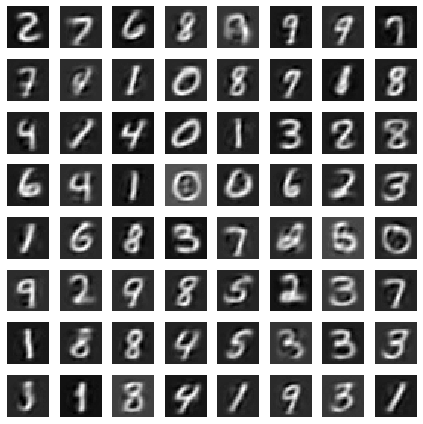

In [37]:
reconstructions = autoencoder.getReconstructions()
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.imshow(reconstructions[i], cmap='gray', interpolation='none')
    
plt.tight_layout()

# 4. Transfer Learning

## 4.1 The pretrained Classifier

Now we initialize another classifier but this time with the pretrained encoder.

In [38]:
from exercise_code.models import Classifier

hparams = {}
########################################################################
# TODO: Define your hyper parameters here!                             #
########################################################################

hparams = {"batch_size":32,
           "lr":5e-4,
           "weight_decay":1e-3,
           "nn_hidden_layer1":1500,
           "nn_hidden_layer2":700,
#            "nn_hidden_layer3":128,
           "num_classes":10,
    
}

########################################################################
#                           END OF YOUR CODE                           #
########################################################################
classifier_pretrained = Classifier(hparams, encoder_pretrained, train, val, test)

Now specify another trainer that we will use the pretrained classifier to compare its performance with
the classifier we trained on only the labeled data. You might need to optimize the parameters defined above in order to achieve a reasonable result.

In [42]:
trainer = None
cls_logger = TensorBoardLogger(save_dir='lightning_logs', name="pretrained_cls_logs")

########################################################################
# TODO: Define your trainer! Don't forget the logger.                  # 
# Hint: Choose an appropriate logging frequency in your trainer.       #
########################################################################


trainer = pl.Trainer(
    max_epochs=1000,
    logger=cls_logger,
    log_every_n_steps=1,
    gpus=1 if torch.cuda.is_available() else None
)

########################################################################
#                           END OF YOUR CODE                           #
########################################################################
trainer.fit(classifier_pretrained) # train the standard classifier

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Encoder    | 2.2 M 
1 | model   | Sequential | 7.0 K 
---------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.941     Total estimated model params size (MB)


Epoch 0:  50%|██████████████████████████▌                          | 4/8 [00:00<00:00, 100.13it/s, loss=0.204, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|███████████████████████████                           | 4/8 [00:00<00:00, 28.58it/s, loss=0.188, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|███████████████████████████                           | 4/8 [00:00<00:00, 16.67it/s, loss=0.194, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|███████████████████████████                           | 4/8 [00:00<00:00, 11.36it/s, loss=0.173, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|███████████████████████████                           | 4/8 [00:00<00:00,  8.75it/s, loss=0.162, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 5:  50%|███████████████████████████                           | 4/8 [00:00<00:00,  7.15it/s, loss=0.134, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|███████████████████████████▌                           | 4/8 [00:00<00:00,  6.05

Epoch 11:  50%|██████████████████████████▌                          | 4/8 [00:01<00:01,  3.36it/s, loss=0.036, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 12:  50%|██████████████████████████                          | 4/8 [00:01<00:01,  3.06it/s, loss=0.0327, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 13:  50%|██████████████████████████                          | 4/8 [00:01<00:01,  2.83it/s, loss=0.0311, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 14:  50%|██████████████████████████                          | 4/8 [00:01<00:01,  2.63it/s, loss=0.0283, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 15:  50%|██████████████████████████                          | 4/8 [00:01<00:01,  2.45it/s, loss=0.0245, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 16:  50%|██████████████████████████                          | 4/8 [00:01<00:01,  2.31it/s, loss=0.0233, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 17:  50%|██████████████████████████                          | 4/8 [00:01<00:01,  2.18it

Epoch 21:  50%|██████████████████████████                          | 4/8 [00:02<00:02,  1.79it/s, loss=0.0223, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 22:  50%|██████████████████████████                          | 4/8 [00:02<00:02,  1.71it/s, loss=0.0207, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 23:  50%|███████████████████████████                           | 4/8 [00:02<00:02,  1.64it/s, loss=0.02, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 24:  50%|██████████████████████████                          | 4/8 [00:02<00:02,  1.58it/s, loss=0.0204, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 25:  50%|██████████████████████████                          | 4/8 [00:02<00:02,  1.52it/s, loss=0.0223, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 26:  50%|██████████████████████████                          | 4/8 [00:02<00:02,  1.46it/s, loss=0.0213, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 27:  50%|██████████████████████████                          | 4/8 [00:02<00:02,  1.41it

Epoch 32:  50%|██████████████████████████                          | 4/8 [00:03<00:03,  1.20it/s, loss=0.0173, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 33:  50%|██████████████████████████                          | 4/8 [00:03<00:03,  1.16it/s, loss=0.0163, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 34:  50%|██████████████████████████                          | 4/8 [00:03<00:03,  1.13it/s, loss=0.0162, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|██████████████████████████                          | 4/8 [00:03<00:03,  1.09it/s, loss=0.0163, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 36:  50%|██████████████████████████                          | 4/8 [00:03<00:03,  1.07it/s, loss=0.0162, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 37:  50%|██████████████████████████                          | 4/8 [00:03<00:03,  1.04it/s, loss=0.0159, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 38:  50%|██████████████████████████                          | 4/8 [00:03<00:03,  1.01it

Epoch 42:  50%|██████████████████████████                          | 4/8 [00:04<00:04,  1.09s/it, loss=0.0158, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 43:  50%|██████████████████████████                          | 4/8 [00:04<00:04,  1.11s/it, loss=0.0152, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 44:  50%|██████████████████████████▌                          | 4/8 [00:04<00:04,  1.14s/it, loss=0.016, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 45:  50%|██████████████████████████                          | 4/8 [00:04<00:04,  1.16s/it, loss=0.0169, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 46:  50%|██████████████████████████                          | 4/8 [00:04<00:04,  1.19s/it, loss=0.0172, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 47:  50%|██████████████████████████                          | 4/8 [00:04<00:04,  1.21s/it, loss=0.0169, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 48:  50%|██████████████████████████                          | 4/8 [00:04<00:04,  1.24s/

Epoch 53:  50%|██████████████████████████                          | 4/8 [00:05<00:05,  1.36s/it, loss=0.0149, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 54:  50%|██████████████████████████                          | 4/8 [00:05<00:05,  1.39s/it, loss=0.0151, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 55:  50%|██████████████████████████                          | 4/8 [00:05<00:05,  1.41s/it, loss=0.0151, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 56:  50%|██████████████████████████                          | 4/8 [00:05<00:05,  1.44s/it, loss=0.0155, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 57:  50%|██████████████████████████                          | 4/8 [00:05<00:05,  1.46s/it, loss=0.0149, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 58:  50%|██████████████████████████                          | 4/8 [00:05<00:05,  1.49s/it, loss=0.0141, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 59:  50%|██████████████████████████                          | 4/8 [00:06<00:06,  1.51s/

Epoch 63:  50%|██████████████████████████                          | 4/8 [00:06<00:06,  1.62s/it, loss=0.0132, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 64:  50%|██████████████████████████                          | 4/8 [00:06<00:06,  1.64s/it, loss=0.0129, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 65:  50%|██████████████████████████                          | 4/8 [00:06<00:06,  1.67s/it, loss=0.0127, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 66:  50%|██████████████████████████                          | 4/8 [00:06<00:06,  1.69s/it, loss=0.0128, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 67:  50%|██████████████████████████                          | 4/8 [00:06<00:06,  1.72s/it, loss=0.0125, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 68:  50%|██████████████████████████                          | 4/8 [00:06<00:06,  1.75s/it, loss=0.0127, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 69:  50%|██████████████████████████                          | 4/8 [00:07<00:07,  1.77s/

Epoch 74:  50%|██████████████████████████                          | 4/8 [00:07<00:07,  1.90s/it, loss=0.0142, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 75:  50%|██████████████████████████                          | 4/8 [00:07<00:07,  1.93s/it, loss=0.0145, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 76:  50%|██████████████████████████                          | 4/8 [00:07<00:07,  1.95s/it, loss=0.0146, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 77:  50%|██████████████████████████                          | 4/8 [00:07<00:07,  1.98s/it, loss=0.0133, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 78:  50%|██████████████████████████                          | 4/8 [00:08<00:08,  2.00s/it, loss=0.0152, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 79:  50%|██████████████████████████                          | 4/8 [00:08<00:08,  2.03s/it, loss=0.0146, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 80:  50%|██████████████████████████                          | 4/8 [00:08<00:08,  2.06s/

Epoch 84:  50%|██████████████████████████                          | 4/8 [00:08<00:08,  2.16s/it, loss=0.0158, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 85:  50%|██████████████████████████                          | 4/8 [00:08<00:08,  2.19s/it, loss=0.0159, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 86:  50%|██████████████████████████                          | 4/8 [00:08<00:08,  2.21s/it, loss=0.0151, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 87:  50%|██████████████████████████                          | 4/8 [00:08<00:08,  2.24s/it, loss=0.0145, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 88:  50%|██████████████████████████                          | 4/8 [00:09<00:09,  2.27s/it, loss=0.0143, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 89:  50%|██████████████████████████                          | 4/8 [00:09<00:09,  2.29s/it, loss=0.0125, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 90:  50%|██████████████████████████                          | 4/8 [00:09<00:09,  2.32s/

Epoch 95:  50%|██████████████████████████                          | 4/8 [00:09<00:09,  2.45s/it, loss=0.0127, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 96:  50%|██████████████████████████                          | 4/8 [00:09<00:09,  2.47s/it, loss=0.0129, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 97:  50%|██████████████████████████                          | 4/8 [00:10<00:10,  2.50s/it, loss=0.0126, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 98:  50%|██████████████████████████                          | 4/8 [00:10<00:10,  2.53s/it, loss=0.0132, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 99:  50%|██████████████████████████                          | 4/8 [00:10<00:10,  2.55s/it, loss=0.0126, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 100:  50%|█████████████████████████▌                         | 4/8 [00:10<00:10,  2.58s/it, loss=0.0125, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 101:  50%|█████████████████████████▌                         | 4/8 [00:10<00:10,  2.60s/

Epoch 105:  50%|██████████████████████████                          | 4/8 [00:10<00:10,  2.71s/it, loss=0.012, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 106:  50%|█████████████████████████▌                         | 4/8 [00:10<00:10,  2.74s/it, loss=0.0121, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 107:  50%|█████████████████████████▌                         | 4/8 [00:11<00:11,  2.76s/it, loss=0.0125, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 108:  50%|█████████████████████████▌                         | 4/8 [00:11<00:11,  2.79s/it, loss=0.0126, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 109:  50%|██████████████████████████                          | 4/8 [00:11<00:11,  2.81s/it, loss=0.013, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 110:  50%|█████████████████████████▌                         | 4/8 [00:11<00:11,  2.84s/it, loss=0.0131, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 111:  50%|█████████████████████████▌                         | 4/8 [00:11<00:11,  2.86s/

Epoch 116:  50%|█████████████████████████▌                         | 4/8 [00:11<00:11,  2.99s/it, loss=0.0128, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 117:  50%|█████████████████████████▌                         | 4/8 [00:12<00:12,  3.02s/it, loss=0.0128, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 118:  50%|█████████████████████████▌                         | 4/8 [00:12<00:12,  3.04s/it, loss=0.0126, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 119:  50%|█████████████████████████▌                         | 4/8 [00:12<00:12,  3.07s/it, loss=0.0122, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 120:  50%|██████████████████████████                          | 4/8 [00:12<00:12,  3.09s/it, loss=0.012, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 121:  50%|█████████████████████████▌                         | 4/8 [00:12<00:12,  3.12s/it, loss=0.0127, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 122:  50%|█████████████████████████▌                         | 4/8 [00:12<00:12,  3.14s/

Epoch 126:  50%|█████████████████████████▌                         | 4/8 [00:12<00:12,  3.24s/it, loss=0.0112, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 127:  50%|█████████████████████████▌                         | 4/8 [00:13<00:13,  3.27s/it, loss=0.0113, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 128:  50%|█████████████████████████▌                         | 4/8 [00:13<00:13,  3.30s/it, loss=0.0114, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 129:  50%|█████████████████████████▌                         | 4/8 [00:13<00:13,  3.32s/it, loss=0.0117, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 130:  50%|█████████████████████████▌                         | 4/8 [00:13<00:13,  3.35s/it, loss=0.0119, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 131:  50%|█████████████████████████▌                         | 4/8 [00:13<00:13,  3.38s/it, loss=0.0116, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 132:  50%|█████████████████████████▌                         | 4/8 [00:13<00:13,  3.40s/

Epoch 137:  50%|█████████████████████████▌                         | 4/8 [00:14<00:14,  3.53s/it, loss=0.0122, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 138:  50%|█████████████████████████▌                         | 4/8 [00:14<00:14,  3.55s/it, loss=0.0122, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 139:  50%|█████████████████████████▌                         | 4/8 [00:14<00:14,  3.58s/it, loss=0.0118, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 140:  50%|█████████████████████████▌                         | 4/8 [00:14<00:14,  3.61s/it, loss=0.0119, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 141:  50%|█████████████████████████▌                         | 4/8 [00:14<00:14,  3.63s/it, loss=0.0115, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 142:  50%|█████████████████████████▌                         | 4/8 [00:14<00:14,  3.66s/it, loss=0.0118, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 143:  50%|█████████████████████████▌                         | 4/8 [00:14<00:14,  3.68s/

Epoch 147:  50%|█████████████████████████▌                         | 4/8 [00:15<00:15,  3.79s/it, loss=0.0111, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 148:  50%|█████████████████████████▌                         | 4/8 [00:15<00:15,  3.82s/it, loss=0.0113, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 149:  50%|█████████████████████████▌                         | 4/8 [00:15<00:15,  3.84s/it, loss=0.0115, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 150:  50%|█████████████████████████▌                         | 4/8 [00:15<00:15,  3.87s/it, loss=0.0114, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 151:  50%|█████████████████████████▌                         | 4/8 [00:15<00:15,  3.90s/it, loss=0.0118, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 152:  50%|█████████████████████████▌                         | 4/8 [00:15<00:15,  3.92s/it, loss=0.0123, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 153:  50%|█████████████████████████▌                         | 4/8 [00:15<00:15,  3.95s/

Epoch 158:  50%|█████████████████████████▌                         | 4/8 [00:16<00:16,  4.07s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 159:  50%|█████████████████████████▌                         | 4/8 [00:16<00:16,  4.10s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 160:  50%|█████████████████████████▌                         | 4/8 [00:16<00:16,  4.12s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 161:  50%|█████████████████████████▌                         | 4/8 [00:16<00:16,  4.15s/it, loss=0.0109, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 162:  50%|█████████████████████████▌                         | 4/8 [00:16<00:16,  4.17s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 163:  50%|█████████████████████████▌                         | 4/8 [00:16<00:16,  4.20s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 164:  50%|█████████████████████████▌                         | 4/8 [00:16<00:16,  4.22s/

Epoch 168:  50%|█████████████████████████▌                         | 4/8 [00:17<00:17,  4.32s/it, loss=0.0111, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 169:  50%|█████████████████████████▌                         | 4/8 [00:17<00:17,  4.35s/it, loss=0.0117, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 170:  50%|█████████████████████████▌                         | 4/8 [00:17<00:17,  4.37s/it, loss=0.0112, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 171:  50%|█████████████████████████▌                         | 4/8 [00:17<00:17,  4.40s/it, loss=0.0114, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 172:  50%|█████████████████████████▌                         | 4/8 [00:17<00:17,  4.42s/it, loss=0.0114, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 173:  50%|██████████████████████████                          | 4/8 [00:17<00:17,  4.45s/it, loss=0.011, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 174:  50%|█████████████████████████▌                         | 4/8 [00:17<00:17,  4.47s/

Epoch 179:  50%|██████████████████████████▌                          | 4/8 [00:18<00:18,  4.59s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 180:  50%|█████████████████████████▌                         | 4/8 [00:18<00:18,  4.62s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 181:  50%|█████████████████████████▌                         | 4/8 [00:18<00:18,  4.65s/it, loss=0.0105, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 182:  50%|█████████████████████████▌                         | 4/8 [00:18<00:18,  4.67s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 183:  50%|█████████████████████████▌                         | 4/8 [00:18<00:18,  4.70s/it, loss=0.0105, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 184:  50%|█████████████████████████▌                         | 4/8 [00:18<00:18,  4.73s/it, loss=0.0105, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 185:  50%|██████████████████████████                          | 4/8 [00:19<00:19,  4.75s

Epoch 189:  50%|█████████████████████████▌                         | 4/8 [00:19<00:19,  4.85s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 190:  50%|█████████████████████████▌                         | 4/8 [00:19<00:19,  4.87s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 191:  50%|█████████████████████████▌                         | 4/8 [00:19<00:19,  4.90s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 192:  50%|█████████████████████████▌                         | 4/8 [00:19<00:19,  4.92s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 193:  50%|█████████████████████████▌                         | 4/8 [00:19<00:19,  4.95s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 194:  50%|█████████████████████████▌                         | 4/8 [00:19<00:19,  4.97s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 195:  50%|█████████████████████████▌                         | 4/8 [00:19<00:19,  4.99s/

Epoch 200:  50%|█████████████████████████▌                         | 4/8 [00:20<00:20,  5.12s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 201:  50%|█████████████████████████▌                         | 4/8 [00:20<00:20,  5.14s/it, loss=0.0112, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 202:  50%|█████████████████████████▌                         | 4/8 [00:20<00:20,  5.17s/it, loss=0.0113, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 203:  50%|█████████████████████████▌                         | 4/8 [00:20<00:20,  5.19s/it, loss=0.0111, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 204:  50%|█████████████████████████▌                         | 4/8 [00:20<00:20,  5.22s/it, loss=0.0119, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 205:  50%|█████████████████████████▌                         | 4/8 [00:20<00:20,  5.24s/it, loss=0.0122, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 206:  50%|█████████████████████████▌                         | 4/8 [00:21<00:21,  5.26s/

Epoch 210:  50%|█████████████████████████▌                         | 4/8 [00:21<00:21,  5.36s/it, loss=0.0124, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 211:  50%|█████████████████████████▌                         | 4/8 [00:21<00:21,  5.39s/it, loss=0.0118, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 212:  50%|█████████████████████████▌                         | 4/8 [00:21<00:21,  5.42s/it, loss=0.0114, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 213:  50%|█████████████████████████▌                         | 4/8 [00:21<00:21,  5.45s/it, loss=0.0113, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 214:  50%|█████████████████████████▌                         | 4/8 [00:21<00:21,  5.47s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 215:  50%|█████████████████████████▌                         | 4/8 [00:21<00:21,  5.49s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 216:  50%|█████████████████████████▌                         | 4/8 [00:22<00:22,  5.52s/

Epoch 221:  50%|█████████████████████████▌                         | 4/8 [00:22<00:22,  5.64s/it, loss=0.0112, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 222:  50%|█████████████████████████▌                         | 4/8 [00:22<00:22,  5.67s/it, loss=0.0116, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 223:  50%|█████████████████████████▌                         | 4/8 [00:22<00:22,  5.69s/it, loss=0.0114, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 224:  50%|█████████████████████████▌                         | 4/8 [00:22<00:22,  5.72s/it, loss=0.0113, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 225:  50%|█████████████████████████▌                         | 4/8 [00:22<00:22,  5.74s/it, loss=0.0111, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 226:  50%|█████████████████████████▌                         | 4/8 [00:23<00:23,  5.77s/it, loss=0.0113, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 227:  50%|█████████████████████████▌                         | 4/8 [00:23<00:23,  5.79s/

Epoch 231:  50%|█████████████████████████▌                         | 4/8 [00:23<00:23,  5.89s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 232:  50%|█████████████████████████▌                         | 4/8 [00:23<00:23,  5.92s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 233:  50%|█████████████████████████▌                         | 4/8 [00:23<00:23,  5.94s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 234:  50%|█████████████████████████▌                         | 4/8 [00:23<00:23,  5.97s/it, loss=0.0116, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 235:  50%|█████████████████████████▌                         | 4/8 [00:23<00:23,  5.99s/it, loss=0.0114, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 236:  50%|█████████████████████████▌                         | 4/8 [00:24<00:24,  6.02s/it, loss=0.0119, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 237:  50%|█████████████████████████▌                         | 4/8 [00:24<00:24,  6.04s/

Epoch 242:  50%|█████████████████████████▌                         | 4/8 [00:24<00:24,  6.17s/it, loss=0.0122, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 243:  50%|█████████████████████████▌                         | 4/8 [00:24<00:24,  6.19s/it, loss=0.0114, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 244:  50%|█████████████████████████▌                         | 4/8 [00:24<00:24,  6.21s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 245:  50%|█████████████████████████▌                         | 4/8 [00:24<00:24,  6.24s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 246:  50%|█████████████████████████                         | 4/8 [00:25<00:25,  6.26s/it, loss=0.00928, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 247:  50%|█████████████████████████                         | 4/8 [00:25<00:25,  6.29s/it, loss=0.00929, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 248:  50%|█████████████████████████                         | 4/8 [00:25<00:25,  6.31s/i

Epoch 252:  50%|█████████████████████████▌                         | 4/8 [00:25<00:25,  6.40s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 253:  50%|█████████████████████████▌                         | 4/8 [00:25<00:25,  6.43s/it, loss=0.0105, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 254:  50%|█████████████████████████▌                         | 4/8 [00:25<00:25,  6.45s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 255:  50%|█████████████████████████▌                         | 4/8 [00:25<00:25,  6.47s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 256:  50%|█████████████████████████▌                         | 4/8 [00:25<00:25,  6.50s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 257:  50%|█████████████████████████▌                         | 4/8 [00:26<00:26,  6.52s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 258:  50%|█████████████████████████▌                         | 4/8 [00:26<00:26,  6.55s/

Epoch 263:  50%|█████████████████████████▌                         | 4/8 [00:26<00:26,  6.66s/it, loss=0.0119, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 264:  50%|██████████████████████████                          | 4/8 [00:26<00:26,  6.69s/it, loss=0.011, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 265:  50%|█████████████████████████▌                         | 4/8 [00:26<00:26,  6.71s/it, loss=0.0113, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 266:  50%|█████████████████████████▌                         | 4/8 [00:26<00:26,  6.73s/it, loss=0.0111, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 267:  50%|█████████████████████████▌                         | 4/8 [00:27<00:27,  6.76s/it, loss=0.0114, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 268:  50%|█████████████████████████▌                         | 4/8 [00:27<00:27,  6.78s/it, loss=0.0109, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 269:  50%|██████████████████████████                          | 4/8 [00:27<00:27,  6.80s

Epoch 273:  50%|█████████████████████████                         | 4/8 [00:27<00:27,  6.90s/it, loss=0.00935, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 274:  50%|█████████████████████████                         | 4/8 [00:27<00:27,  6.92s/it, loss=0.00932, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 275:  50%|██████████████████████████▌                          | 4/8 [00:27<00:27,  6.94s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 276:  50%|█████████████████████████▌                         | 4/8 [00:27<00:27,  6.97s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 277:  50%|█████████████████████████▌                         | 4/8 [00:27<00:27,  6.99s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 278:  50%|██████████████████████████                          | 4/8 [00:28<00:28,  7.01s/it, loss=0.011, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 279:  50%|█████████████████████████▌                         | 4/8 [00:28<00:28,  7.04s/

Epoch 284:  50%|█████████████████████████▌                         | 4/8 [00:28<00:28,  7.15s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 285:  50%|█████████████████████████▌                         | 4/8 [00:28<00:28,  7.18s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 286:  50%|█████████████████████████▌                         | 4/8 [00:28<00:28,  7.20s/it, loss=0.0114, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 287:  50%|█████████████████████████▌                         | 4/8 [00:28<00:28,  7.23s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 288:  50%|█████████████████████████▌                         | 4/8 [00:29<00:29,  7.25s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 289:  50%|█████████████████████████▌                         | 4/8 [00:29<00:29,  7.27s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 290:  50%|█████████████████████████▌                         | 4/8 [00:29<00:29,  7.30s/

Epoch 294:  50%|█████████████████████████▌                         | 4/8 [00:29<00:29,  7.39s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 295:  50%|█████████████████████████▌                         | 4/8 [00:29<00:29,  7.42s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 296:  50%|█████████████████████████▌                         | 4/8 [00:29<00:29,  7.44s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 297:  50%|█████████████████████████                         | 4/8 [00:29<00:29,  7.46s/it, loss=0.00979, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 298:  50%|██████████████████████████▌                          | 4/8 [00:29<00:29,  7.49s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 299:  50%|█████████████████████████▌                         | 4/8 [00:30<00:30,  7.51s/it, loss=0.0099, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 300:  50%|█████████████████████████                         | 4/8 [00:30<00:30,  7.54s/i

Epoch 305:  50%|█████████████████████████▌                         | 4/8 [00:30<00:30,  7.66s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 306:  50%|█████████████████████████▌                         | 4/8 [00:30<00:30,  7.68s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 307:  50%|█████████████████████████▌                         | 4/8 [00:30<00:30,  7.70s/it, loss=0.0116, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 308:  50%|█████████████████████████▌                         | 4/8 [00:30<00:30,  7.73s/it, loss=0.0116, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 309:  50%|█████████████████████████▌                         | 4/8 [00:31<00:31,  7.75s/it, loss=0.0118, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 310:  50%|█████████████████████████▌                         | 4/8 [00:31<00:31,  7.78s/it, loss=0.0115, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 311:  50%|█████████████████████████▌                         | 4/8 [00:31<00:31,  7.80s/

Epoch 315:  50%|█████████████████████████▌                         | 4/8 [00:31<00:31,  7.90s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 316:  50%|█████████████████████████▌                         | 4/8 [00:31<00:31,  7.92s/it, loss=0.0105, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 317:  50%|█████████████████████████▌                         | 4/8 [00:31<00:31,  7.95s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 318:  50%|██████████████████████████                          | 4/8 [00:31<00:31,  7.97s/it, loss=0.011, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 319:  50%|█████████████████████████▌                         | 4/8 [00:31<00:31,  7.99s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 320:  50%|█████████████████████████▌                         | 4/8 [00:32<00:32,  8.02s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 321:  50%|█████████████████████████▌                         | 4/8 [00:32<00:32,  8.04s/

Epoch 326:  50%|██████████████████████████                          | 4/8 [00:32<00:32,  8.16s/it, loss=0.011, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 327:  50%|██████████████████████████                          | 4/8 [00:32<00:32,  8.18s/it, loss=0.011, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 328:  50%|█████████████████████████▌                         | 4/8 [00:32<00:32,  8.20s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 329:  50%|█████████████████████████                         | 4/8 [00:32<00:32,  8.23s/it, loss=0.00975, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 330:  50%|█████████████████████████                         | 4/8 [00:32<00:32,  8.25s/it, loss=0.00987, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 331:  50%|█████████████████████████                         | 4/8 [00:33<00:33,  8.27s/it, loss=0.00995, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 332:  50%|█████████████████████████                         | 4/8 [00:33<00:33,  8.30s/i

Epoch 336:  50%|█████████████████████████▌                         | 4/8 [00:33<00:33,  8.39s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 337:  50%|█████████████████████████▌                         | 4/8 [00:33<00:33,  8.41s/it, loss=0.0111, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 338:  50%|█████████████████████████▌                         | 4/8 [00:33<00:33,  8.43s/it, loss=0.0112, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 339:  50%|█████████████████████████▌                         | 4/8 [00:33<00:33,  8.46s/it, loss=0.0114, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 340:  50%|██████████████████████████                          | 4/8 [00:33<00:33,  8.48s/it, loss=0.011, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 341:  50%|██████████████████████████                          | 4/8 [00:34<00:34,  8.50s/it, loss=0.011, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 342:  50%|█████████████████████████▌                         | 4/8 [00:34<00:34,  8.53s/

Epoch 347:  50%|█████████████████████████▌                         | 4/8 [00:34<00:34,  8.64s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 348:  50%|█████████████████████████▌                         | 4/8 [00:34<00:34,  8.67s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 349:  50%|█████████████████████████▌                         | 4/8 [00:34<00:34,  8.69s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 350:  50%|█████████████████████████                         | 4/8 [00:34<00:34,  8.71s/it, loss=0.00971, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 351:  50%|█████████████████████████                         | 4/8 [00:34<00:34,  8.74s/it, loss=0.00956, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 352:  50%|█████████████████████████                         | 4/8 [00:35<00:35,  8.76s/it, loss=0.00931, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 353:  50%|█████████████████████████                         | 4/8 [00:35<00:35,  8.78s/i

Epoch 357:  50%|█████████████████████████                         | 4/8 [00:35<00:35,  8.88s/it, loss=0.00983, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 358:  50%|██████████████████████████▌                          | 4/8 [00:35<00:35,  8.90s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 359:  50%|█████████████████████████▌                         | 4/8 [00:35<00:35,  8.92s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 360:  50%|██████████████████████████▌                          | 4/8 [00:35<00:35,  8.95s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 361:  50%|█████████████████████████                         | 4/8 [00:35<00:35,  8.97s/it, loss=0.00986, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 362:  50%|█████████████████████████                         | 4/8 [00:35<00:35,  8.99s/it, loss=0.00988, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 363:  50%|█████████████████████████                         | 4/8 [00:36<00:36,  9.01s/i

Epoch 368:  50%|█████████████████████████                         | 4/8 [00:36<00:36,  9.13s/it, loss=0.00953, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 369:  50%|█████████████████████████                         | 4/8 [00:36<00:36,  9.15s/it, loss=0.00956, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 370:  50%|█████████████████████████▌                         | 4/8 [00:36<00:36,  9.18s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 371:  50%|█████████████████████████▌                         | 4/8 [00:36<00:36,  9.20s/it, loss=0.0112, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 372:  50%|█████████████████████████▌                         | 4/8 [00:36<00:36,  9.22s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 373:  50%|█████████████████████████▌                         | 4/8 [00:36<00:36,  9.25s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 374:  50%|█████████████████████████▌                         | 4/8 [00:37<00:37,  9.27s/

Epoch 378:  50%|█████████████████████████▌                         | 4/8 [00:37<00:37,  9.36s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 379:  50%|█████████████████████████▌                         | 4/8 [00:37<00:37,  9.39s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 380:  50%|█████████████████████████▌                         | 4/8 [00:37<00:37,  9.41s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 381:  50%|█████████████████████████                         | 4/8 [00:37<00:37,  9.43s/it, loss=0.00999, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 382:  50%|█████████████████████████▌                         | 4/8 [00:37<00:37,  9.45s/it, loss=0.0097, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 383:  50%|█████████████████████████▌                         | 4/8 [00:37<00:37,  9.48s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 384:  50%|█████████████████████████▌                         | 4/8 [00:38<00:38,  9.50s/

Epoch 389:  50%|█████████████████████████▌                         | 4/8 [00:38<00:38,  9.62s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 390:  50%|██████████████████████████▌                          | 4/8 [00:38<00:38,  9.64s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 391:  50%|█████████████████████████                         | 4/8 [00:38<00:38,  9.67s/it, loss=0.00974, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 392:  50%|█████████████████████████                         | 4/8 [00:38<00:38,  9.69s/it, loss=0.00937, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 393:  50%|█████████████████████████                         | 4/8 [00:38<00:38,  9.71s/it, loss=0.00949, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 394:  50%|█████████████████████████                         | 4/8 [00:38<00:38,  9.74s/it, loss=0.00975, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 395:  50%|█████████████████████████                         | 4/8 [00:39<00:39,  9.76s/i

Epoch 399:  50%|██████████████████████████▌                          | 4/8 [00:39<00:39,  9.86s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 400:  50%|█████████████████████████▌                         | 4/8 [00:39<00:39,  9.88s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 401:  50%|█████████████████████████▌                         | 4/8 [00:39<00:39,  9.90s/it, loss=0.0109, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 402:  50%|█████████████████████████▌                         | 4/8 [00:39<00:39,  9.93s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 403:  50%|█████████████████████████▌                         | 4/8 [00:39<00:39,  9.95s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 404:  50%|█████████████████████████▌                         | 4/8 [00:39<00:39,  9.97s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 405:  50%|█████████████████████████                         | 4/8 [00:39<00:39, 10.00s/i

Epoch 410:  50%|█████████████████████████▌                         | 4/8 [00:40<00:40, 10.12s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 411:  50%|█████████████████████████▌                         | 4/8 [00:40<00:40, 10.14s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 412:  50%|█████████████████████████▌                         | 4/8 [00:40<00:40, 10.16s/it, loss=0.0109, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 413:  50%|█████████████████████████▌                         | 4/8 [00:40<00:40, 10.19s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 414:  50%|█████████████████████████▌                         | 4/8 [00:40<00:40, 10.21s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 415:  50%|█████████████████████████▌                         | 4/8 [00:40<00:40, 10.23s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 416:  50%|█████████████████████████▌                         | 4/8 [00:41<00:41, 10.26s/

Epoch 420:  50%|█████████████████████████▌                         | 4/8 [00:41<00:41, 10.35s/it, loss=0.0105, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 421:  50%|█████████████████████████▌                         | 4/8 [00:41<00:41, 10.37s/it, loss=0.0118, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 422:  50%|█████████████████████████▌                         | 4/8 [00:41<00:41, 10.40s/it, loss=0.0118, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 423:  50%|█████████████████████████▌                         | 4/8 [00:41<00:41, 10.42s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 424:  50%|█████████████████████████▌                         | 4/8 [00:41<00:41, 10.44s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 425:  50%|██████████████████████████                          | 4/8 [00:41<00:41, 10.47s/it, loss=0.011, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 426:  50%|█████████████████████████▌                         | 4/8 [00:41<00:41, 10.49s/

Epoch 431:  50%|█████████████████████████                         | 4/8 [00:42<00:42, 10.61s/it, loss=0.00906, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 432:  50%|█████████████████████████                         | 4/8 [00:42<00:42, 10.63s/it, loss=0.00904, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 433:  50%|██████████████████████████▌                          | 4/8 [00:42<00:42, 10.66s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 434:  50%|██████████████████████████▌                          | 4/8 [00:42<00:42, 10.68s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 435:  50%|█████████████████████████▌                         | 4/8 [00:42<00:42, 10.70s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 436:  50%|█████████████████████████▌                         | 4/8 [00:42<00:42, 10.73s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 437:  50%|█████████████████████████▌                         | 4/8 [00:43<00:43, 10.75s/

Epoch 441:  50%|█████████████████████████▌                         | 4/8 [00:43<00:43, 10.85s/it, loss=0.0105, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 442:  50%|█████████████████████████▌                         | 4/8 [00:43<00:43, 10.87s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 443:  50%|█████████████████████████▌                         | 4/8 [00:43<00:43, 10.90s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 444:  50%|█████████████████████████                         | 4/8 [00:43<00:43, 10.92s/it, loss=0.00985, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 445:  50%|█████████████████████████▌                         | 4/8 [00:43<00:43, 10.95s/it, loss=0.0098, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 446:  50%|█████████████████████████▌                         | 4/8 [00:43<00:43, 10.97s/it, loss=0.0092, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 447:  50%|█████████████████████████                         | 4/8 [00:43<00:43, 10.99s/i

Epoch 452:  50%|█████████████████████████▌                         | 4/8 [00:44<00:44, 11.11s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 453:  50%|█████████████████████████▌                         | 4/8 [00:44<00:44, 11.13s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 454:  50%|█████████████████████████▌                         | 4/8 [00:44<00:44, 11.16s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 455:  50%|█████████████████████████                         | 4/8 [00:44<00:44, 11.18s/it, loss=0.00991, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 456:  50%|█████████████████████████                         | 4/8 [00:44<00:44, 11.20s/it, loss=0.00943, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 457:  50%|█████████████████████████                         | 4/8 [00:44<00:44, 11.23s/it, loss=0.00945, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 458:  50%|█████████████████████████▌                         | 4/8 [00:45<00:45, 11.25s/

Epoch 462:  50%|█████████████████████████▌                         | 4/8 [00:45<00:45, 11.35s/it, loss=0.0111, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 463:  50%|█████████████████████████▌                         | 4/8 [00:45<00:45, 11.37s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 464:  50%|█████████████████████████▌                         | 4/8 [00:45<00:45, 11.39s/it, loss=0.0112, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 465:  50%|█████████████████████████▌                         | 4/8 [00:45<00:45, 11.42s/it, loss=0.0114, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 466:  50%|██████████████████████████                          | 4/8 [00:45<00:45, 11.44s/it, loss=0.011, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 467:  50%|█████████████████████████▌                         | 4/8 [00:45<00:45, 11.46s/it, loss=0.0109, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 468:  50%|██████████████████████████                          | 4/8 [00:45<00:45, 11.49s

Epoch 473:  50%|██████████████████████████▌                          | 4/8 [00:46<00:46, 11.61s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 474:  50%|█████████████████████████▌                         | 4/8 [00:46<00:46, 11.63s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 475:  50%|█████████████████████████                         | 4/8 [00:46<00:46, 11.65s/it, loss=0.00991, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 476:  50%|█████████████████████████                         | 4/8 [00:46<00:46, 11.68s/it, loss=0.00978, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 477:  50%|█████████████████████████                         | 4/8 [00:46<00:46, 11.70s/it, loss=0.00993, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 478:  50%|█████████████████████████                         | 4/8 [00:46<00:46, 11.72s/it, loss=0.00924, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 479:  50%|█████████████████████████                         | 4/8 [00:46<00:46, 11.75s/i

Epoch 483:  50%|█████████████████████████▌                         | 4/8 [00:47<00:47, 11.84s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 484:  50%|█████████████████████████                         | 4/8 [00:47<00:47, 11.87s/it, loss=0.00979, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 485:  50%|█████████████████████████                         | 4/8 [00:47<00:47, 11.89s/it, loss=0.00988, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 486:  50%|█████████████████████████▌                         | 4/8 [00:47<00:47, 11.91s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 487:  50%|█████████████████████████▌                         | 4/8 [00:47<00:47, 11.94s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 488:  50%|█████████████████████████▌                         | 4/8 [00:47<00:47, 11.96s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 489:  50%|██████████████████████████                          | 4/8 [00:47<00:47, 11.98s

Epoch 494:  50%|█████████████████████████▌                         | 4/8 [00:48<00:48, 12.10s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 495:  50%|█████████████████████████▌                         | 4/8 [00:48<00:48, 12.12s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 496:  50%|█████████████████████████▌                         | 4/8 [00:48<00:48, 12.15s/it, loss=0.0105, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 497:  50%|█████████████████████████                         | 4/8 [00:48<00:48, 12.17s/it, loss=0.00989, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 498:  50%|█████████████████████████▌                         | 4/8 [00:48<00:48, 12.19s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 499:  50%|█████████████████████████                         | 4/8 [00:48<00:48, 12.22s/it, loss=0.00982, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 500:  50%|█████████████████████████                         | 4/8 [00:48<00:48, 12.24s/i

Epoch 504:  50%|█████████████████████████                         | 4/8 [00:49<00:49, 12.34s/it, loss=0.00957, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 505:  50%|█████████████████████████                         | 4/8 [00:49<00:49, 12.36s/it, loss=0.00941, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 506:  50%|█████████████████████████▌                         | 4/8 [00:49<00:49, 12.38s/it, loss=0.0095, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 507:  50%|█████████████████████████                         | 4/8 [00:49<00:49, 12.41s/it, loss=0.00967, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 508:  50%|█████████████████████████▌                         | 4/8 [00:49<00:49, 12.43s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 509:  50%|█████████████████████████▌                         | 4/8 [00:49<00:49, 12.46s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 510:  50%|█████████████████████████▌                         | 4/8 [00:49<00:49, 12.48s/

Epoch 515:  50%|█████████████████████████▌                         | 4/8 [00:50<00:50, 12.60s/it, loss=0.0114, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 516:  50%|█████████████████████████▌                         | 4/8 [00:50<00:50, 12.62s/it, loss=0.0114, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 517:  50%|█████████████████████████▌                         | 4/8 [00:50<00:50, 12.65s/it, loss=0.0112, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 518:  50%|█████████████████████████▌                         | 4/8 [00:50<00:50, 12.67s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 519:  50%|█████████████████████████                         | 4/8 [00:50<00:50, 12.69s/it, loss=0.00966, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 520:  50%|█████████████████████████                         | 4/8 [00:50<00:50, 12.72s/it, loss=0.00895, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 521:  50%|█████████████████████████                         | 4/8 [00:50<00:50, 12.74s/i

Epoch 525:  50%|█████████████████████████                         | 4/8 [00:51<00:51, 12.83s/it, loss=0.00979, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 526:  50%|██████████████████████████▌                          | 4/8 [00:51<00:51, 12.86s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 527:  50%|█████████████████████████                         | 4/8 [00:51<00:51, 12.88s/it, loss=0.00996, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 528:  50%|█████████████████████████                         | 4/8 [00:51<00:51, 12.90s/it, loss=0.00967, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 529:  50%|█████████████████████████                         | 4/8 [00:51<00:51, 12.93s/it, loss=0.00975, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 530:  50%|█████████████████████████                         | 4/8 [00:51<00:51, 12.95s/it, loss=0.00959, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 531:  50%|█████████████████████████                         | 4/8 [00:51<00:51, 12.98s/i

Epoch 536:  50%|█████████████████████████▌                         | 4/8 [00:52<00:52, 13.09s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 537:  50%|█████████████████████████▌                         | 4/8 [00:52<00:52, 13.12s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 538:  50%|██████████████████████████▌                          | 4/8 [00:52<00:52, 13.14s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 539:  50%|█████████████████████████                         | 4/8 [00:52<00:52, 13.16s/it, loss=0.00933, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 540:  50%|█████████████████████████                         | 4/8 [00:52<00:52, 13.19s/it, loss=0.00972, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 541:  50%|█████████████████████████                         | 4/8 [00:52<00:52, 13.21s/it, loss=0.00942, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 542:  50%|█████████████████████████                         | 4/8 [00:52<00:52, 13.24s/i

Epoch 546:  50%|█████████████████████████                         | 4/8 [00:53<00:53, 13.33s/it, loss=0.00949, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 547:  50%|█████████████████████████▌                         | 4/8 [00:53<00:53, 13.35s/it, loss=0.0093, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 548:  50%|█████████████████████████                         | 4/8 [00:53<00:53, 13.38s/it, loss=0.00989, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 549:  50%|█████████████████████████                         | 4/8 [00:53<00:53, 13.40s/it, loss=0.00995, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 550:  50%|█████████████████████████                         | 4/8 [00:53<00:53, 13.43s/it, loss=0.00996, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 551:  50%|█████████████████████████                         | 4/8 [00:53<00:53, 13.45s/it, loss=0.00909, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 552:  50%|█████████████████████████                         | 4/8 [00:53<00:53, 13.47s/i

Epoch 557:  50%|█████████████████████████▌                         | 4/8 [00:54<00:54, 13.59s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 558:  50%|█████████████████████████▌                         | 4/8 [00:54<00:54, 13.61s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 559:  50%|█████████████████████████▌                         | 4/8 [00:54<00:54, 13.64s/it, loss=0.0109, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 560:  50%|█████████████████████████▌                         | 4/8 [00:54<00:54, 13.66s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 561:  50%|█████████████████████████▌                         | 4/8 [00:54<00:54, 13.69s/it, loss=0.0105, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 562:  50%|█████████████████████████                         | 4/8 [00:54<00:54, 13.71s/it, loss=0.00979, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 563:  50%|█████████████████████████                         | 4/8 [00:54<00:54, 13.73s/i

Epoch 567:  50%|█████████████████████████                         | 4/8 [00:55<00:55, 13.83s/it, loss=0.00991, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 568:  50%|█████████████████████████▌                         | 4/8 [00:55<00:55, 13.85s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 569:  50%|█████████████████████████▌                         | 4/8 [00:55<00:55, 13.88s/it, loss=0.0105, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 570:  50%|█████████████████████████▌                         | 4/8 [00:55<00:55, 13.90s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 571:  50%|██████████████████████████▌                          | 4/8 [00:55<00:55, 13.93s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 572:  50%|█████████████████████████▌                         | 4/8 [00:55<00:55, 13.95s/it, loss=0.0109, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 573:  50%|█████████████████████████▌                         | 4/8 [00:55<00:55, 13.97s/

Epoch 578:  50%|█████████████████████████                         | 4/8 [00:56<00:56, 14.09s/it, loss=0.00881, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 579:  50%|█████████████████████████                         | 4/8 [00:56<00:56, 14.12s/it, loss=0.00894, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 580:  50%|█████████████████████████▌                         | 4/8 [00:56<00:56, 14.14s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 581:  50%|█████████████████████████▌                         | 4/8 [00:56<00:56, 14.16s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 582:  50%|█████████████████████████▌                         | 4/8 [00:56<00:56, 14.19s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 583:  50%|█████████████████████████▌                         | 4/8 [00:56<00:56, 14.21s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 584:  50%|█████████████████████████▌                         | 4/8 [00:56<00:56, 14.24s/

Epoch 588:  50%|█████████████████████████▌                         | 4/8 [00:57<00:57, 14.33s/it, loss=0.0113, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 589:  50%|█████████████████████████▌                         | 4/8 [00:57<00:57, 14.35s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 590:  50%|█████████████████████████▌                         | 4/8 [00:57<00:57, 14.38s/it, loss=0.0111, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 591:  50%|█████████████████████████▌                         | 4/8 [00:57<00:57, 14.40s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 592:  50%|█████████████████████████▌                         | 4/8 [00:57<00:57, 14.42s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 593:  50%|█████████████████████████                         | 4/8 [00:57<00:57, 14.45s/it, loss=0.00978, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 594:  50%|█████████████████████████▌                         | 4/8 [00:57<00:57, 14.47s/

Epoch 599:  50%|█████████████████████████▌                         | 4/8 [00:58<00:58, 14.59s/it, loss=0.0086, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 600:  50%|█████████████████████████                         | 4/8 [00:58<00:58, 14.62s/it, loss=0.00881, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 601:  50%|█████████████████████████▌                         | 4/8 [00:58<00:58, 14.64s/it, loss=0.0088, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 602:  50%|█████████████████████████                         | 4/8 [00:58<00:58, 14.66s/it, loss=0.00917, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 603:  50%|█████████████████████████                         | 4/8 [00:58<00:58, 14.69s/it, loss=0.00963, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 604:  50%|█████████████████████████                         | 4/8 [00:58<00:58, 14.71s/it, loss=0.00988, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 605:  50%|█████████████████████████                         | 4/8 [00:58<00:58, 14.73s/i

Epoch 609:  50%|█████████████████████████                         | 4/8 [00:59<00:59, 14.83s/it, loss=0.00864, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 610:  50%|█████████████████████████▌                         | 4/8 [00:59<00:59, 14.85s/it, loss=0.0086, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 611:  50%|█████████████████████████                         | 4/8 [00:59<00:59, 14.88s/it, loss=0.00857, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 612:  50%|█████████████████████████▌                         | 4/8 [00:59<00:59, 14.90s/it, loss=0.0088, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 613:  50%|█████████████████████████                         | 4/8 [00:59<00:59, 14.92s/it, loss=0.00937, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 614:  50%|█████████████████████████                         | 4/8 [00:59<00:59, 14.95s/it, loss=0.00946, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 615:  50%|█████████████████████████                         | 4/8 [00:59<00:59, 14.97s/i

Epoch 620:  50%|█████████████████████████                         | 4/8 [01:00<01:00, 15.09s/it, loss=0.00912, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 621:  50%|█████████████████████████                         | 4/8 [01:00<01:00, 15.12s/it, loss=0.00891, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 622:  50%|█████████████████████████▌                         | 4/8 [01:00<01:00, 15.14s/it, loss=0.0091, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 623:  50%|█████████████████████████                         | 4/8 [01:00<01:00, 15.16s/it, loss=0.00903, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 624:  50%|█████████████████████████                         | 4/8 [01:00<01:00, 15.19s/it, loss=0.00905, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 625:  50%|█████████████████████████▌                         | 4/8 [01:00<01:00, 15.21s/it, loss=0.0095, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 626:  50%|█████████████████████████                         | 4/8 [01:00<01:00, 15.23s/i

Epoch 630:  50%|█████████████████████████                         | 4/8 [01:01<01:01, 15.33s/it, loss=0.00986, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 631:  50%|█████████████████████████                         | 4/8 [01:01<01:01, 15.35s/it, loss=0.00993, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 632:  50%|█████████████████████████                         | 4/8 [01:01<01:01, 15.37s/it, loss=0.00975, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 633:  50%|█████████████████████████                         | 4/8 [01:01<01:01, 15.40s/it, loss=0.00944, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 634:  50%|█████████████████████████▌                         | 4/8 [01:01<01:01, 15.42s/it, loss=0.0096, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 635:  50%|█████████████████████████                         | 4/8 [01:01<01:01, 15.44s/it, loss=0.00976, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 636:  50%|█████████████████████████                         | 4/8 [01:01<01:01, 15.47s/i

Epoch 641:  50%|█████████████████████████                         | 4/8 [01:02<01:02, 15.59s/it, loss=0.00992, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 642:  50%|█████████████████████████                         | 4/8 [01:02<01:02, 15.61s/it, loss=0.00981, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 643:  50%|█████████████████████████▌                         | 4/8 [01:02<01:02, 15.63s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 644:  50%|██████████████████████████▌                          | 4/8 [01:02<01:02, 15.66s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 645:  50%|█████████████████████████▌                         | 4/8 [01:02<01:02, 15.68s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 646:  50%|█████████████████████████                         | 4/8 [01:02<01:02, 15.71s/it, loss=0.00974, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 647:  50%|█████████████████████████                         | 4/8 [01:02<01:02, 15.73s/i

Epoch 651:  50%|█████████████████████████                         | 4/8 [01:03<01:03, 15.82s/it, loss=0.00926, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 652:  50%|█████████████████████████                         | 4/8 [01:03<01:03, 15.85s/it, loss=0.00916, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 653:  50%|█████████████████████████▌                         | 4/8 [01:03<01:03, 15.87s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 654:  50%|█████████████████████████▌                         | 4/8 [01:03<01:03, 15.90s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 655:  50%|█████████████████████████▌                         | 4/8 [01:03<01:03, 15.92s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 656:  50%|█████████████████████████▌                         | 4/8 [01:03<01:03, 15.94s/it, loss=0.0105, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 657:  50%|█████████████████████████▌                         | 4/8 [01:03<01:03, 15.97s/

Epoch 662:  50%|█████████████████████████▌                         | 4/8 [01:04<01:04, 16.09s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 663:  50%|█████████████████████████▌                         | 4/8 [01:04<01:04, 16.11s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 664:  50%|██████████████████████████▌                          | 4/8 [01:04<01:04, 16.13s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 665:  50%|██████████████████████████▌                          | 4/8 [01:04<01:04, 16.16s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 666:  50%|█████████████████████████▌                         | 4/8 [01:04<01:04, 16.18s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 667:  50%|█████████████████████████▌                         | 4/8 [01:04<01:04, 16.20s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 668:  50%|█████████████████████████▌                         | 4/8 [01:04<01:04, 16.23s/

Epoch 672:  50%|█████████████████████████                         | 4/8 [01:05<01:05, 16.33s/it, loss=0.00924, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 673:  50%|█████████████████████████                         | 4/8 [01:05<01:05, 16.36s/it, loss=0.00961, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 674:  50%|█████████████████████████                         | 4/8 [01:05<01:05, 16.38s/it, loss=0.00952, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 675:  50%|█████████████████████████                         | 4/8 [01:05<01:05, 16.40s/it, loss=0.00946, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 676:  50%|█████████████████████████                         | 4/8 [01:05<01:05, 16.43s/it, loss=0.00963, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 677:  50%|█████████████████████████                         | 4/8 [01:05<01:05, 16.45s/it, loss=0.00933, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 678:  50%|█████████████████████████                         | 4/8 [01:05<01:05, 16.48s/i

Epoch 683:  50%|█████████████████████████▌                         | 4/8 [01:06<01:06, 16.60s/it, loss=0.0107, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 684:  50%|█████████████████████████▌                         | 4/8 [01:06<01:06, 16.62s/it, loss=0.0114, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 685:  50%|█████████████████████████▌                         | 4/8 [01:06<01:06, 16.65s/it, loss=0.0116, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 686:  50%|█████████████████████████▌                         | 4/8 [01:06<01:06, 16.67s/it, loss=0.0109, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 687:  50%|█████████████████████████▌                         | 4/8 [01:06<01:06, 16.70s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 688:  50%|█████████████████████████▌                         | 4/8 [01:06<01:06, 16.72s/it, loss=0.0105, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 689:  50%|█████████████████████████▌                         | 4/8 [01:06<01:06, 16.75s/

Epoch 693:  50%|█████████████████████████                         | 4/8 [01:07<01:07, 16.84s/it, loss=0.00964, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 694:  50%|█████████████████████████▌                         | 4/8 [01:07<01:07, 16.87s/it, loss=0.0096, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 695:  50%|█████████████████████████                         | 4/8 [01:07<01:07, 16.90s/it, loss=0.00983, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 696:  50%|█████████████████████████                         | 4/8 [01:07<01:07, 16.92s/it, loss=0.00969, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 697:  50%|█████████████████████████                         | 4/8 [01:07<01:07, 16.95s/it, loss=0.00938, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 698:  50%|█████████████████████████                         | 4/8 [01:07<01:07, 16.97s/it, loss=0.00941, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 699:  50%|█████████████████████████                         | 4/8 [01:07<01:07, 16.99s/i

Epoch 704:  50%|█████████████████████████                         | 4/8 [01:08<01:08, 17.12s/it, loss=0.00951, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 705:  50%|█████████████████████████▌                         | 4/8 [01:08<01:08, 17.14s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 706:  50%|█████████████████████████                         | 4/8 [01:08<01:08, 17.17s/it, loss=0.00999, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 707:  50%|█████████████████████████                         | 4/8 [01:08<01:08, 17.19s/it, loss=0.00968, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 708:  50%|█████████████████████████                         | 4/8 [01:08<01:08, 17.22s/it, loss=0.00934, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 709:  50%|█████████████████████████                         | 4/8 [01:08<01:08, 17.24s/it, loss=0.00968, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 710:  50%|█████████████████████████                         | 4/8 [01:09<01:09, 17.27s/i

Epoch 714:  50%|█████████████████████████                         | 4/8 [01:09<01:09, 17.37s/it, loss=0.00927, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 715:  50%|█████████████████████████▌                         | 4/8 [01:09<01:09, 17.39s/it, loss=0.0093, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 716:  50%|█████████████████████████                         | 4/8 [01:09<01:09, 17.42s/it, loss=0.00948, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 717:  50%|█████████████████████████▌                         | 4/8 [01:09<01:09, 17.44s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 718:  50%|█████████████████████████▌                         | 4/8 [01:09<01:09, 17.47s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 719:  50%|█████████████████████████▌                         | 4/8 [01:09<01:09, 17.49s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 720:  50%|█████████████████████████▌                         | 4/8 [01:10<01:10, 17.52s/

Epoch 725:  50%|█████████████████████████                         | 4/8 [01:10<01:10, 17.63s/it, loss=0.00918, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 726:  50%|█████████████████████████                         | 4/8 [01:10<01:10, 17.66s/it, loss=0.00914, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 727:  50%|█████████████████████████                         | 4/8 [01:10<01:10, 17.68s/it, loss=0.00887, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 728:  50%|█████████████████████████                         | 4/8 [01:10<01:10, 17.71s/it, loss=0.00837, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 729:  50%|█████████████████████████                         | 4/8 [01:10<01:10, 17.73s/it, loss=0.00826, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 730:  50%|█████████████████████████                         | 4/8 [01:11<01:11, 17.75s/it, loss=0.00815, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 731:  50%|█████████████████████████                         | 4/8 [01:11<01:11, 17.78s/i

Epoch 735:  50%|█████████████████████████                         | 4/8 [01:11<01:11, 17.87s/it, loss=0.00964, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 736:  50%|█████████████████████████▌                         | 4/8 [01:11<01:11, 17.89s/it, loss=0.0094, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 737:  50%|█████████████████████████                         | 4/8 [01:11<01:11, 17.92s/it, loss=0.00953, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 738:  50%|█████████████████████████                         | 4/8 [01:11<01:11, 17.94s/it, loss=0.00948, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 739:  50%|█████████████████████████                         | 4/8 [01:11<01:11, 17.96s/it, loss=0.00873, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 740:  50%|█████████████████████████                         | 4/8 [01:11<01:11, 17.99s/it, loss=0.00851, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 741:  50%|█████████████████████████                         | 4/8 [01:12<01:12, 18.01s/i

Epoch 746:  50%|█████████████████████████                         | 4/8 [01:12<01:12, 18.13s/it, loss=0.00935, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 747:  50%|█████████████████████████▌                         | 4/8 [01:12<01:12, 18.15s/it, loss=0.0095, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 748:  50%|█████████████████████████                         | 4/8 [01:12<01:12, 18.18s/it, loss=0.00991, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 749:  50%|█████████████████████████▌                         | 4/8 [01:12<01:12, 18.20s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 750:  50%|█████████████████████████                         | 4/8 [01:12<01:12, 18.23s/it, loss=0.00961, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 751:  50%|█████████████████████████                         | 4/8 [01:12<01:12, 18.25s/it, loss=0.00958, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 752:  50%|█████████████████████████▌                         | 4/8 [01:13<01:13, 18.27s/

Epoch 756:  50%|█████████████████████████                         | 4/8 [01:13<01:13, 18.37s/it, loss=0.00823, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 757:  50%|█████████████████████████                         | 4/8 [01:13<01:13, 18.39s/it, loss=0.00808, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 758:  50%|█████████████████████████                         | 4/8 [01:13<01:13, 18.41s/it, loss=0.00798, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 759:  50%|█████████████████████████                         | 4/8 [01:13<01:13, 18.44s/it, loss=0.00866, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 760:  50%|█████████████████████████                         | 4/8 [01:13<01:13, 18.46s/it, loss=0.00886, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 761:  50%|█████████████████████████                         | 4/8 [01:13<01:13, 18.48s/it, loss=0.00903, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 762:  50%|█████████████████████████                         | 4/8 [01:14<01:14, 18.51s/i

Epoch 767:  50%|█████████████████████████                         | 4/8 [01:14<01:14, 18.62s/it, loss=0.00913, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 768:  50%|██████████████████████████                          | 4/8 [01:14<01:14, 18.65s/it, loss=0.009, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 769:  50%|█████████████████████████                         | 4/8 [01:14<01:14, 18.67s/it, loss=0.00989, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 770:  50%|█████████████████████████                         | 4/8 [01:14<01:14, 18.69s/it, loss=0.00979, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 771:  50%|█████████████████████████▌                         | 4/8 [01:14<01:14, 18.72s/it, loss=0.0094, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 772:  50%|█████████████████████████                         | 4/8 [01:14<01:14, 18.74s/it, loss=0.00923, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 773:  50%|█████████████████████████                         | 4/8 [01:15<01:15, 18.76s/i

Epoch 777:  50%|█████████████████████████                         | 4/8 [01:15<01:15, 18.86s/it, loss=0.00912, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 778:  50%|█████████████████████████                         | 4/8 [01:15<01:15, 18.88s/it, loss=0.00948, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 779:  50%|█████████████████████████                         | 4/8 [01:15<01:15, 18.90s/it, loss=0.00939, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 780:  50%|██████████████████████████▌                          | 4/8 [01:15<01:15, 18.93s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 781:  50%|██████████████████████████▌                          | 4/8 [01:15<01:15, 18.95s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 782:  50%|█████████████████████████▌                         | 4/8 [01:15<01:15, 18.97s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 783:  50%|█████████████████████████▌                         | 4/8 [01:15<01:15, 19.00s/

Epoch 788:  50%|█████████████████████████▌                         | 4/8 [01:16<01:16, 19.11s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 789:  50%|█████████████████████████                         | 4/8 [01:16<01:16, 19.14s/it, loss=0.00996, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 790:  50%|█████████████████████████▌                         | 4/8 [01:16<01:16, 19.16s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 791:  50%|█████████████████████████                         | 4/8 [01:16<01:16, 19.19s/it, loss=0.00989, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 792:  50%|█████████████████████████                         | 4/8 [01:16<01:16, 19.21s/it, loss=0.00957, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 793:  50%|█████████████████████████                         | 4/8 [01:16<01:16, 19.23s/it, loss=0.00925, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 794:  50%|█████████████████████████                         | 4/8 [01:17<01:17, 19.26s/i

Epoch 798:  50%|█████████████████████████                         | 4/8 [01:17<01:17, 19.35s/it, loss=0.00894, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 799:  50%|█████████████████████████                         | 4/8 [01:17<01:17, 19.37s/it, loss=0.00896, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 800:  50%|█████████████████████████                         | 4/8 [01:17<01:17, 19.40s/it, loss=0.00888, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 801:  50%|█████████████████████████                         | 4/8 [01:17<01:17, 19.42s/it, loss=0.00889, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 802:  50%|█████████████████████████                         | 4/8 [01:17<01:17, 19.45s/it, loss=0.00885, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 803:  50%|█████████████████████████                         | 4/8 [01:17<01:17, 19.47s/it, loss=0.00864, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 804:  50%|█████████████████████████                         | 4/8 [01:17<01:17, 19.49s/i

Epoch 809:  50%|█████████████████████████                         | 4/8 [01:18<01:18, 19.61s/it, loss=0.00863, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 810:  50%|█████████████████████████                         | 4/8 [01:18<01:18, 19.63s/it, loss=0.00823, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 811:  50%|█████████████████████████                         | 4/8 [01:18<01:18, 19.66s/it, loss=0.00826, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 812:  50%|█████████████████████████                         | 4/8 [01:18<01:18, 19.68s/it, loss=0.00965, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 813:  50%|█████████████████████████▌                         | 4/8 [01:18<01:18, 19.71s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 814:  50%|█████████████████████████▌                         | 4/8 [01:18<01:18, 19.73s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 815:  50%|█████████████████████████▌                         | 4/8 [01:19<01:19, 19.75s/

Epoch 819:  50%|█████████████████████████▌                         | 4/8 [01:19<01:19, 19.85s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 820:  50%|█████████████████████████                         | 4/8 [01:19<01:19, 19.87s/it, loss=0.00994, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 821:  50%|█████████████████████████▌                         | 4/8 [01:19<01:19, 19.90s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 822:  50%|█████████████████████████                         | 4/8 [01:19<01:19, 19.92s/it, loss=0.00909, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 823:  50%|█████████████████████████                         | 4/8 [01:19<01:19, 19.95s/it, loss=0.00904, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 824:  50%|█████████████████████████                         | 4/8 [01:19<01:19, 19.97s/it, loss=0.00885, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 825:  50%|█████████████████████████                         | 4/8 [01:19<01:19, 19.99s/i

Epoch 830:  50%|█████████████████████████▌                         | 4/8 [01:20<01:20, 20.11s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 831:  50%|█████████████████████████▌                         | 4/8 [01:20<01:20, 20.14s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 832:  50%|█████████████████████████▌                         | 4/8 [01:20<01:20, 20.17s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 833:  50%|█████████████████████████▌                         | 4/8 [01:20<01:20, 20.20s/it, loss=0.0106, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 834:  50%|█████████████████████████▌                         | 4/8 [01:20<01:20, 20.22s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 835:  50%|█████████████████████████▌                         | 4/8 [01:21<01:21, 20.25s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 836:  50%|█████████████████████████▌                         | 4/8 [01:21<01:21, 20.28s/

Epoch 840:  50%|█████████████████████████                         | 4/8 [01:21<01:21, 20.37s/it, loss=0.00973, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 841:  50%|█████████████████████████                         | 4/8 [01:21<01:21, 20.40s/it, loss=0.00952, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 842:  50%|█████████████████████████                         | 4/8 [01:21<01:21, 20.43s/it, loss=0.00948, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 843:  50%|█████████████████████████▌                         | 4/8 [01:21<01:21, 20.45s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 844:  50%|█████████████████████████                         | 4/8 [01:21<01:21, 20.47s/it, loss=0.00993, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 845:  50%|█████████████████████████                         | 4/8 [01:22<01:22, 20.50s/it, loss=0.00913, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 846:  50%|█████████████████████████                         | 4/8 [01:22<01:22, 20.52s/i

Epoch 851:  50%|█████████████████████████                         | 4/8 [01:22<01:22, 20.65s/it, loss=0.00971, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 852:  50%|█████████████████████████▌                         | 4/8 [01:22<01:22, 20.67s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 853:  50%|██████████████████████████                          | 4/8 [01:22<01:22, 20.70s/it, loss=0.011, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 854:  50%|█████████████████████████                         | 4/8 [01:22<01:22, 20.72s/it, loss=0.00984, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 855:  50%|█████████████████████████                         | 4/8 [01:22<01:22, 20.75s/it, loss=0.00997, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 856:  50%|█████████████████████████                         | 4/8 [01:23<01:23, 20.78s/it, loss=0.00996, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 857:  50%|█████████████████████████▌                         | 4/8 [01:23<01:23, 20.80s/

Epoch 861:  50%|█████████████████████████                         | 4/8 [01:23<01:23, 20.91s/it, loss=0.00994, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 862:  50%|█████████████████████████                         | 4/8 [01:23<01:23, 20.93s/it, loss=0.00934, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 863:  50%|██████████████████████████▌                          | 4/8 [01:23<01:23, 20.96s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 864:  50%|█████████████████████████▌                         | 4/8 [01:23<01:23, 20.99s/it, loss=0.0105, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 865:  50%|██████████████████████████▌                          | 4/8 [01:24<01:24, 21.01s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 866:  50%|█████████████████████████▌                         | 4/8 [01:24<01:24, 21.04s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 867:  50%|█████████████████████████▌                         | 4/8 [01:24<01:24, 21.06s/

Epoch 872:  50%|█████████████████████████                         | 4/8 [01:24<01:24, 21.19s/it, loss=0.00946, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 873:  50%|█████████████████████████                         | 4/8 [01:24<01:24, 21.22s/it, loss=0.00932, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 874:  50%|█████████████████████████                         | 4/8 [01:24<01:24, 21.25s/it, loss=0.00882, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 875:  50%|█████████████████████████                         | 4/8 [01:25<01:25, 21.27s/it, loss=0.00857, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 876:  50%|█████████████████████████                         | 4/8 [01:25<01:25, 21.30s/it, loss=0.00906, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 877:  50%|█████████████████████████                         | 4/8 [01:25<01:25, 21.32s/it, loss=0.00962, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 878:  50%|█████████████████████████                         | 4/8 [01:25<01:25, 21.35s/i

Epoch 882:  50%|█████████████████████████                         | 4/8 [01:25<01:25, 21.45s/it, loss=0.00878, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 883:  50%|█████████████████████████                         | 4/8 [01:25<01:25, 21.48s/it, loss=0.00841, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 884:  50%|█████████████████████████                         | 4/8 [01:26<01:26, 21.50s/it, loss=0.00854, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 885:  50%|█████████████████████████                         | 4/8 [01:26<01:26, 21.53s/it, loss=0.00827, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 886:  50%|█████████████████████████                         | 4/8 [01:26<01:26, 21.55s/it, loss=0.00847, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 887:  50%|█████████████████████████                         | 4/8 [01:26<01:26, 21.58s/it, loss=0.00831, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 888:  50%|█████████████████████████                         | 4/8 [01:26<01:26, 21.60s/i

Epoch 893:  50%|██████████████████████████                          | 4/8 [01:26<01:26, 21.73s/it, loss=0.009, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 894:  50%|█████████████████████████                         | 4/8 [01:27<01:27, 21.75s/it, loss=0.00895, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 895:  50%|█████████████████████████                         | 4/8 [01:27<01:27, 21.78s/it, loss=0.00897, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 896:  50%|█████████████████████████                         | 4/8 [01:27<01:27, 21.80s/it, loss=0.00907, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 897:  50%|█████████████████████████                         | 4/8 [01:27<01:27, 21.83s/it, loss=0.00915, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 898:  50%|█████████████████████████                         | 4/8 [01:27<01:27, 21.85s/it, loss=0.00908, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 899:  50%|█████████████████████████                         | 4/8 [01:27<01:27, 21.88s/i

Epoch 903:  50%|█████████████████████████▌                         | 4/8 [01:27<01:27, 21.98s/it, loss=0.0093, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 904:  50%|█████████████████████████                         | 4/8 [01:28<01:28, 22.01s/it, loss=0.00967, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 905:  50%|█████████████████████████                         | 4/8 [01:28<01:28, 22.03s/it, loss=0.00941, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 906:  50%|█████████████████████████                         | 4/8 [01:28<01:28, 22.06s/it, loss=0.00937, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 907:  50%|█████████████████████████                         | 4/8 [01:28<01:28, 22.08s/it, loss=0.00865, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 908:  50%|█████████████████████████                         | 4/8 [01:28<01:28, 22.11s/it, loss=0.00871, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 909:  50%|█████████████████████████                         | 4/8 [01:28<01:28, 22.13s/i

Epoch 914:  50%|█████████████████████████▌                         | 4/8 [01:29<01:29, 22.26s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 915:  50%|█████████████████████████▌                         | 4/8 [01:29<01:29, 22.29s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 916:  50%|█████████████████████████▌                         | 4/8 [01:29<01:29, 22.32s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 917:  50%|█████████████████████████▌                         | 4/8 [01:29<01:29, 22.34s/it, loss=0.0105, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 918:  50%|█████████████████████████▌                         | 4/8 [01:29<01:29, 22.37s/it, loss=0.0109, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 919:  50%|█████████████████████████▌                         | 4/8 [01:29<01:29, 22.39s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 920:  50%|█████████████████████████▌                         | 4/8 [01:29<01:29, 22.42s/

Epoch 924:  50%|█████████████████████████                         | 4/8 [01:30<01:30, 22.52s/it, loss=0.00996, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 925:  50%|█████████████████████████                         | 4/8 [01:30<01:30, 22.55s/it, loss=0.00994, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 926:  50%|█████████████████████████▌                         | 4/8 [01:30<01:30, 22.57s/it, loss=0.0099, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 927:  50%|█████████████████████████▌                         | 4/8 [01:30<01:30, 22.60s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 928:  50%|█████████████████████████▌                         | 4/8 [01:30<01:30, 22.62s/it, loss=0.0097, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 929:  50%|█████████████████████████                         | 4/8 [01:30<01:30, 22.65s/it, loss=0.00977, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 930:  50%|█████████████████████████                         | 4/8 [01:30<01:30, 22.68s/i

Epoch 935:  50%|█████████████████████████▌                         | 4/8 [01:31<01:31, 22.81s/it, loss=0.0096, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 936:  50%|█████████████████████████                         | 4/8 [01:31<01:31, 22.83s/it, loss=0.00937, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 937:  50%|█████████████████████████                         | 4/8 [01:31<01:31, 22.86s/it, loss=0.00996, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 938:  50%|█████████████████████████▌                         | 4/8 [01:31<01:31, 22.89s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 939:  50%|██████████████████████████                          | 4/8 [01:31<01:31, 22.91s/it, loss=0.011, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 940:  50%|█████████████████████████▌                         | 4/8 [01:31<01:31, 22.94s/it, loss=0.0105, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 941:  50%|█████████████████████████▌                         | 4/8 [01:31<01:31, 22.96s/

Epoch 945:  50%|█████████████████████████                         | 4/8 [01:32<01:32, 23.06s/it, loss=0.00872, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 946:  50%|█████████████████████████▌                         | 4/8 [01:32<01:32, 23.09s/it, loss=0.0086, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 947:  50%|█████████████████████████                         | 4/8 [01:32<01:32, 23.11s/it, loss=0.00866, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 948:  50%|█████████████████████████                         | 4/8 [01:32<01:32, 23.14s/it, loss=0.00908, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 949:  50%|█████████████████████████                         | 4/8 [01:32<01:32, 23.16s/it, loss=0.00881, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 950:  50%|█████████████████████████                         | 4/8 [01:32<01:32, 23.19s/it, loss=0.00881, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 951:  50%|█████████████████████████▌                         | 4/8 [01:32<01:32, 23.21s/

Epoch 956:  50%|█████████████████████████                         | 4/8 [01:33<01:33, 23.34s/it, loss=0.00918, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 957:  50%|█████████████████████████                         | 4/8 [01:33<01:33, 23.37s/it, loss=0.00934, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 958:  50%|█████████████████████████                         | 4/8 [01:33<01:33, 23.39s/it, loss=0.00909, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 959:  50%|█████████████████████████                         | 4/8 [01:33<01:33, 23.42s/it, loss=0.00952, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 960:  50%|█████████████████████████▌                         | 4/8 [01:33<01:33, 23.44s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 961:  50%|█████████████████████████▌                         | 4/8 [01:33<01:33, 23.47s/it, loss=0.0101, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 962:  50%|█████████████████████████▌                         | 4/8 [01:33<01:33, 23.50s/

Epoch 966:  50%|█████████████████████████                         | 4/8 [01:34<01:34, 23.60s/it, loss=0.00977, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 967:  50%|█████████████████████████▌                         | 4/8 [01:34<01:34, 23.63s/it, loss=0.0103, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 968:  50%|██████████████████████████▌                          | 4/8 [01:34<01:34, 23.65s/it, loss=0.01, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 969:  50%|█████████████████████████▌                         | 4/8 [01:34<01:34, 23.68s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 970:  50%|█████████████████████████▌                         | 4/8 [01:34<01:34, 23.70s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 971:  50%|█████████████████████████▌                         | 4/8 [01:34<01:34, 23.73s/it, loss=0.0108, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 972:  50%|█████████████████████████▌                         | 4/8 [01:35<01:35, 23.76s/

Epoch 977:  50%|█████████████████████████                         | 4/8 [01:35<01:35, 23.88s/it, loss=0.00977, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 978:  50%|█████████████████████████▌                         | 4/8 [01:35<01:35, 23.91s/it, loss=0.0102, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 979:  50%|█████████████████████████                         | 4/8 [01:35<01:35, 23.94s/it, loss=0.00996, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 980:  50%|█████████████████████████▌                         | 4/8 [01:35<01:35, 23.96s/it, loss=0.0104, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 981:  50%|█████████████████████████▌                         | 4/8 [01:35<01:35, 23.98s/it, loss=0.0111, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 982:  50%|██████████████████████████                          | 4/8 [01:36<01:36, 24.01s/it, loss=0.011, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 983:  50%|█████████████████████████▌                         | 4/8 [01:36<01:36, 24.03s/

Epoch 987:  50%|█████████████████████████▌                         | 4/8 [01:36<01:36, 24.14s/it, loss=0.0113, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 988:  50%|█████████████████████████▌                         | 4/8 [01:36<01:36, 24.16s/it, loss=0.0112, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 989:  50%|█████████████████████████▌                         | 4/8 [01:36<01:36, 24.19s/it, loss=0.0105, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 990:  50%|█████████████████████████                         | 4/8 [01:36<01:36, 24.22s/it, loss=0.00949, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 991:  50%|█████████████████████████                         | 4/8 [01:36<01:36, 24.24s/it, loss=0.00895, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 992:  50%|█████████████████████████                         | 4/8 [01:37<01:37, 24.27s/it, loss=0.00846, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 993:  50%|█████████████████████████                         | 4/8 [01:37<01:37, 24.29s/i

Epoch 998:  50%|█████████████████████████                         | 4/8 [01:37<01:37, 24.42s/it, loss=0.00882, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 999:  50%|█████████████████████████                         | 4/8 [01:37<01:37, 24.45s/it, loss=0.00862, v_num=7]
Validation: 0it [00:00, ?it/s]
Epoch 999: 100%|██████████████████████████████████████████████████| 8/8 [01:37<00:00, 12.23s/it, loss=0.00862, v_num=7]


Let's have a look at the validation accuracy of the two different classifiers and compare them. And don't forget that you can also monitor your training in TensorBoard.

We will only look at the test accuracy and compare our two classifiers with respect to that in the very end.

In [43]:
print("Validation accuracy when training from scratch: {}%".format(classifier.getAcc(classifier.val_dataloader())[1]*100))
print("Validation accuracy with pretraining: {}%".format(classifier_pretrained.getAcc(classifier.val_dataloader())[1]*100))

Validation accuracy when training from scratch: 48.0%
Validation accuracy with pretraining: 71.0%


Now that everything is working, feel free to play around with different architectures. As you've seen, it's really easy to define your model or do changes there.

To pass this submission, you'll need an accuracy of **55%**.

# Save your model & Report Test Accuracy

When you've done with your **hyperparameter tuning**, have achieved **at least 55% validation accuracy** and are happy with your final model, you can save it here.

Before that, please check again whether the number of parameters is below 5 Mio and the file size is below 20 MB.

When your final model is saved, we'll lastly report the test accuracy.

In [44]:
from exercise_code.Util import test_and_save

print("Test accuracy when training from scratch: {}%".format(classifier.getAcc()[1]*100))
print('\nNow to the pretrained classifier:')
test_and_save(classifier_pretrained)

Test accuracy when training from scratch: 45.0%

Now to the pretrained classifier:
Validation-Accuracy: 71.0%
FYI: Your model has 2.235 mio. params.
Great! Your model size is less than 20 MB and will be accepted :)
Your model has been saved and is ready to be submitted. NOW, let's check the test-accuracy.
Test-Accuracy: 71.0%


In [45]:
# Now zip the folder for upload
from exercise_code.submit import submit_exercise

submit_exercise('../output/exercise08')

relevant folders: ['exercise_code', 'models']
notebooks files: ['1_Autoencoder_PyTorch_Lightning.ipynb', 'Optional-BatchNormalization&Dropout.ipynb']
Adding folder exercise_code
Adding folder models
Adding notebook 1_Autoencoder_PyTorch_Lightning.ipynb
Adding notebook Optional-BatchNormalization&Dropout.ipynb
Zipping successful! Zip is stored under: W:\Python\I2DL\output\exercise08.zip


Congrats! You've now finished your first autoencoder and transferred the weights to a classifier! Much easier than in plain numpy, right? But wait, to complete the exercise, submit your final model to [our submission portal](https://i2dl.dvl.in.tum.de/) - you should be already familiar with the procedure. Next, it is time to get started with some more complex neural networks and tasks in the upcoming exercises. See you next week!

# Submission Goals

- Goal: Successfully implement a fully connected autoencoder for MNIST with Pytorch Lightning and transfer the encoder weights to a classifier.

- Passing Criteria: There are no unit tests that check specific components of your code. The only thing that's required to pass the submission, is your model to reach at least **55% accuracy** on __our__ test dataset. The submission system will show you a number between 0 and 100 which corresponds to your accuracy.

- Submission start: __June 28, 2022 14.00__
- Submission deadline : __July 04, 2022 11.59__ 
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for bonus.

# [Exercise Review](https://docs.google.com/forms/d/e/1FAIpQLScwZArz6ogLqBEj--ItB6unKcv0u9gWLj8bspeiATrDnFH9hA/viewform)

We are always interested in your opinion. Now that you have finished this exercise, we would like you to give us some feedback about the time required to finish the submission and/or work through the notebooks. Please take the short time to fill out our [review form](https://docs.google.com/forms/d/e/1FAIpQLScwZArz6ogLqBEj--ItB6unKcv0u9gWLj8bspeiATrDnFH9hA/viewform) for this exercise so that we can do better next time! :)